# 02_MARES_mooring_DATA-Analysis

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import geofunc.shapes as geoshape
import geofunc.vectors as vectors
import data_unibremen.SIC as unisic
import data_osisaf.icedrift_lr as osidrift
import data_nsidc.icedrift as icedrift
import timeseries.adjust as tseries
import geofunc.vectors as vectors

import timeseries.analyze as tanalyze

sys.path.append('../')
import functions as fn



from scipy import stats


plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)


In [2]:

# open region polygon
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


## Import data

In [3]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [4]:
df = pd.read_csv('../data/compiled_stats.csv')
last_days = df.time[(df.final_day)&(df.single_day==False)].values

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
    

df['si_km'] = df['si'] * units('cm/s').to('km/day') 
df['alongi_km'] = vectors.comp_along_theta(df['ui'], df['vi'], 165*units('degree')) * units('cm/s').to('km/day')


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_20887/2199633763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_20887/2199633763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_20887/2199633763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

### Compile open dates 2016-2019

In [10]:

time_ranges = [slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23)),
                  slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))]

open_years = ['2016_2017', '2017_2018']

data = {}

data['time'] = np.array([], dtype=np.datetime64)

for cat in ['iht', 'ihc', 'iht_lower', 'ihc_lower']:
    data[cat] = np.array([])
    
for cat in ['easterly','northerly', 'windspeed', 'windangle']:
    data[cat] = np.array([])
    data[f"{cat}_21bf"] = np.array([])

cats = ['dT', 'sig0', 'shelf', 'Sp']
deps = ['dma', 'sfc']

for cat in cats:
    for dep in deps:
        data[f"{cat}_{dep}"] = np.array([])
        data[f"{cat}_{dep}_lp"] = np.array([])
        data[f"{cat}_{dep}_16bf"] = np.array([])


for time_range, open_year in zip(time_ranges, open_years):
    
    
    # hourly winds
    #-------------------
    filename = f"../data/forcing/regional_hourly_era_{time_range.stop.year}_v7.nc"
    with xr.open_dataset(filename) as ds:
        
        ds['angle'] = vectors.vector_angle(ds.u10.values, ds.v10.values).magnitude
        ds['speed'] = np.sqrt(ds.u10**2 + ds.v10**2)
        
        # time adjustments
        #-----------------------------------------
        # this would lag measurements by 21 hours (to match later ocean properties time)
        lagged_ds = ds.shift(time=21)
        
        # select actual time range
        ds = ds.sel(time = time_range)
        lagged_ds = lagged_ds.sel(time = time_range)
    
        for lab, DS in zip(['', '_21bf'], [ds, lagged_ds]):
            data[f"easterly{lab}"] = np.append(data[f"easterly{lab}"], -DS.u10.values)
            data[f"northerly{lab}"] = np.append(data[f"northerly{lab}"], -DS.v10.values)
            data[f"windspeed{lab}"] = np.append(data[f"windspeed{lab}"], DS.speed.values)
            data[f"windangle{lab}"] = np.append(data[f"windangle{lab}"], DS.angle.values)
    
    
    main_path = "/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/"
    
    # ocean velocity data
    #-----------------------------------------
    ds = xr.open_dataset(main_path + F"M1_hourly_tempsalinity_{open_year}.nc")
    ds['dT'] = ds.Ct-ds.Tf
    
    
    # time adjustments
    #-----------------------------------------
    # time-interp over missing data (max 24 hr)
    ds = ds.interpolate_na(dim='time', method='linear', use_coordinate=True, limit=24)
    
    # 30-day rolling mean
    ds_lp = ds.rolling(time=30*24, center=True).mean()
    
    # select actual time range
    ds = ds.sel(time = time_range)
    ds_lp = ds_lp.sel(time = time_range)
    data['time'] = np.append(data['time'], ds.time.values)
    
    # save data
    #----------
    for cat in ['dT', 'sig0', 'Sp']:
        
        # hourly
        #-------
        for dep, dat in zip(deps, [ds[cat].mean('depth'), 
                                   ds[cat].sel(depth = ds.depth.max())]):

            var = f"{cat}_{dep}"
            data[var] = np.append(data[var], dat)


        # low-passed
        #-----------
        for dep, dat in zip(deps, [ds_lp[cat].mean('depth'), 
                                   ds_lp[cat].sel(depth = ds_lp.depth.max())]):

            var = f"{cat}_{dep}_lp"
            data[var] = np.append(data[var], dat)
            
            
    # ocean velocity data
    #-----------------------------------------
    ds = xr.open_dataset(main_path + F"M1_hourly_ocean_currents_{open_year}.nc")
    
    ds['shelf'] = vectors.comp_along_theta(ds.u, ds.v, 145*units('degree'))
    
    # time adjustments
    #-----------------------------------------
    # time-interp over missing data (max 24 hr)
    ds = ds.interpolate_na(dim='time', method='linear', use_coordinate=True, limit=24)
    
    # this would lag oc. measurements by 16 hours (to match later ocean properties time)
    lagged_ds = ds.shift(time=16)

    # select actual time range
    ds = ds.sel(time = time_range)
    lagged_ds = lagged_ds.sel(time = time_range)
    

    # save data
    #----------
    for cat in ['shelf']:
        
        # hourly
        #-------
        for dep, dat in zip(deps, [ds[cat].mean('depth'), 
                                   ds[cat].sel(depth = ds.depth.max())]):

            var = f"{cat}_{dep}"
            data[var] = np.append(data[var], dat)
            
        # low-passed
        #-----------
        for dep, dat in zip(deps, [lagged_ds[cat].mean('depth'), 
                                   lagged_ds[cat].sel(depth = lagged_ds.depth.max())]):

            var = f"{cat}_{dep}_16bf"
            data[var] = np.append(data[var], dat)
    
    
    # heat transport data
    #-----------------------------------------
    ds = xr.open_dataset(f'../data/oht_M1_{open_year}.nc')
    
    ds = ds.sel(time = time_range)
    
    ds['shelf'] = vectors.comp_along_theta(ds['u_val_ext'], ds['v_val_ext'], 145*units('degree'))* units('m/s')
    
    # ----- upper estimate -------
    ds['heat'] = cst['Cp_o']* (ds['dT_val_ext']) * units('delta_degC') * (1025.5 * units('kg/m**3'))
    ds['heat_transport'] = ds['heat'] * ds['shelf']
    
    iht = ds['heat_transport'].integrate('depth')
    ihc = ds['heat'].integrate('depth')

    data['iht'] = np.append(data['iht'], iht.values * units('J/(m s)'))
    data['ihc'] = np.append(data['ihc'], ihc.values * units('J/(m**2)'))
    
    # ----- lower estimate -------
    ds['heat_lower'] = cst['Cp_o']* (ds['dT_cold']) * units('delta_degC') * (1025.5 * units('kg/m**3'))
    ds['heat_transport_lower'] = ds['heat_lower'] * ds['shelf']
    
    iht_lower = ds['heat_transport_lower'].integrate('depth')
    ihc_lower = ds['heat_lower'].integrate('depth')

    data['iht_lower'] = np.append(data['iht_lower'], iht_lower.values * units('J/(m s)'))
    data['ihc_lower'] = np.append(data['ihc_lower'], ihc_lower.values * units('J/(m**2)'))

    # double checked those match by-hand trapezoidal integration below
    # dz = ds.z.diff('z').values[0] * units('m')
    # IHT = 0.5*np.sum(ds['heat_transport'][:-1, :].values + ds['heat_transport'][1:, :].values, axis=0) * dz
    # IHC = 0.5*np.sum(ds['heat'][:-1, :].values + ds['heat'][1:, :].values, axis=0) * dz


data['sig0_sfc_anom'] = data['sig0_sfc'] - data['sig0_sfc_lp']
data['sig0_dma_anom'] = data['sig0_dma'] - data['sig0_dma_lp']


data['time'] = pd.to_datetime(data['time'])
Y1 = data['time'] < datetime(2017,9,1)
Y2 = data['time'] > datetime(2017,9,1)




for cat in ['length', 'extent', 'event_day', 'day_before_event', 'day_after_event']:
    data[cat] = np.array([])
    
for cat in [ 'final_day', 'outside_event']:
    data[cat] = np.array([], dtype=bool)
    

for time in data['time'][::24]:
    
    match_time = (pd.to_datetime(df['time']) == time-timedelta(hours=time.hour))
    
    for ii in range(24):
        data['length'] = np.append(data['length'], df[match_time].length_145max.item())
        data['extent'] = np.append(data['extent'], df[match_time].extent.item())
        data['final_day'] = np.append(data['final_day'], df[match_time].final_day.item())
        
        data['event_day'] = np.append(data['event_day'], df[match_time].event_day.item())
        data['day_before_event'] = np.append(data['day_before_event'], df[match_time].day_before_event.item())
        data['day_after_event'] = np.append(data['day_after_event'], df[match_time].day_after_event.item())

In [11]:
well_after = (data['day_after_event']>1) + (data['day_after_event']==-999)
well_before = (data['day_before_event']<-1) + (data['day_before_event']==-999)

outside = ((data['length'] == 0) & ((well_after) & (well_before)))
data['outside_event'] = outside


open_ = (data['length'] > 0) 
comp_ = (data['length'] == 0)
cons_ = (data['outside_event']==True)


In [12]:
def dir_conds(dff, cat):
    
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':
        
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 7.5)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 11.5)
    return speed_cond

<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:74: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:126: SyntaxWarning: invalid escape sequence '\m'
<>:157: SyntaxWarning: invalid escape sequence '\m'
<>:161: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:74: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:126: SyntaxWarning: invalid escape sequence '\m'
<>:157: SyntaxWarning: invalid escape sequence '\m'
<>:161: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_20887/1973671995.py:68: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='$\mathrm{m\;s^{-1}}$'+'\n',
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_20887/1973671995.py:74: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='both', cb_

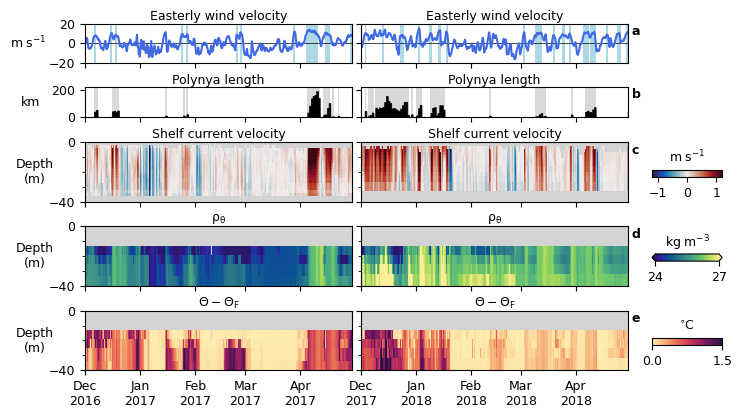

In [8]:
fig, axs = plt.subplots(5,2,figsize=(7,4.5), gridspec_kw={'height_ratios':[0.65,0.5,1,1,1]})


bot_kw = {'color':'lightcoral', 'lw':1, 'ls':'solid', 'zorder':-1}#'dashes':(1,1),
sfc_kw = {'color':'r', 'lw':1, 'zorder':1}

for open_year, time_range, axS, axT, axC in zip(open_years, time_ranges, axs[3,:], axs[4,:], axs[2,:]):
    
    ax = axC
    ax.set_ylim(-40,0)
    ax.patch.set_facecolor('lightgray')
    ax.yaxis.set_major_locator(MultipleLocator(40))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
    
    dsc = xr.open_dataset(main_path + F"M1_hourly_ocean_currents_{open_year}.nc")
    dsc = dsc.interpolate_na(dim='depth', method='linear', use_coordinate=True, limit=5)
    dsc = dsc.interpolate_na(dim='time', method='linear', use_coordinate=True, limit=12)
    dsc['shelf'] = vectors.comp_along_theta(dsc.u, dsc.v, 145*units('degree'))
    dsc = dsc.sel(time = time_range)
    meshC = ax.pcolormesh(dsc.time.values, dsc.depth.values, dsc.shelf.values, cmap=cmocean.cm.balance, vmin=-1.2, vmax=1.2)
    
    
    ds = xr.open_dataset(main_path + F"M1_hourly_tempsalinity_{open_year}.nc")
    ds = ds.interpolate_na(dim='depth', method='linear', use_coordinate=True, limit=5)
    ds = ds.interpolate_na(dim='time', method='linear', use_coordinate=True, limit=12)
#     ds['sig0_lp'] = ds.sig0.rolling(time=30*24, center=True).mean()
#     ds['sig0_anom'] = ds['sig0'] - ds['sig0_lp']
    ds['dT'] = ds.Ct-ds.Tf
    ds = ds.sel(time = time_range)
    
    
    
    ax = axS
    ax.set_ylim(-40,0)
    ax.patch.set_facecolor('lightgray')
    ax.yaxis.set_major_locator(MultipleLocator(40))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    meshS = ax.pcolormesh(ds.time, ds.depth, ds.sig0, vmin=24, vmax=27, cmap=cmocean.cm.haline)
    
    ax = axT
    ax.set_ylim(-40,0)
    ax.patch.set_facecolor('lightgray')
    ax.yaxis.set_major_locator(MultipleLocator(40))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
#     ax.yaxis.set_major_locator(MultipleLocator(2))
    meshT = ax.pcolormesh(ds.time, ds.depth, ds.dT, vmin=0, vmax=1.5, cmap=cmocean.cm.matter)
    



for JJ in [1,]:

    Y1 = data['time'] < datetime(2017,9,1)

    ax = axs[JJ,0]
    for time in data['time'][(data['length']>0)&(Y1==True)][::24]:
        ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color=[0.85,0.85,0.85], zorder=-100)

    ax = axs[JJ,1]
    for time in data['time'][(data['length']>0)&(Y1==False)][::24]:
        ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color=[0.85,0.85,0.85], zorder=-100)


plotter.add_colorbar(fig, axs[2,1], [meshC], cb_placement='right', cb_orientation='horizontal', 
                 cb_width=0.1, cb_length_fraction=[0.35,0.45], cb_pad=0.035, cb_ticks=[-1,0,1], 
                 cb_ticklabels='auto', cb_extend='neither', cb_label='$\mathrm{m\;s^{-1}}$'+'\n',
                 labelpad = -5, cb_label_placement='top', cb_tick_placement='auto', tick_kwargs=None, 
                 cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])

plotter.add_colorbar(fig, axs[3,1], [meshS], cb_placement='right', cb_orientation='horizontal', 
                 cb_width=0.1, cb_length_fraction=[0.35,0.45], cb_pad=0.035, cb_ticks=[24,27], 
                 cb_ticklabels='auto', cb_extend='both', cb_label='$\mathrm{kg\;m^{-3}}$',  
                 labelpad = 5, cb_label_placement='top', cb_tick_placement='auto', tick_kwargs=None, 
                 cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 1.5])


plotter.add_colorbar(fig, axs[4,1], [meshT], cb_placement='right', cb_orientation='horizontal', 
                 cb_width=0.1, cb_length_fraction=[0.35,0.45], cb_pad=0.035, cb_ticks=[0,1.5], 
                 cb_ticklabels='auto', cb_extend='neither', cb_label='$\mathrm{^{\circ}C}$'+'\n',
                 labelpad = -5, cb_label_placement='top', cb_tick_placement='auto', tick_kwargs=None, 
                 cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])

# ------------ easterly wind -------------------
Y1 = data['time'] < datetime(2017,9,1)
for ax in axs[0,:]:
    ax.set_ylim(-20,20)
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.axhline(0, c='k', lw=0.5, zorder=-100)
axs[0,0].plot(data['time'][Y1==True], data['easterly'][Y1==True], lw=1.5, color='royalblue')
axs[0,1].plot(data['time'][Y1==False], data['easterly'][Y1==False], lw=1.5, color='royalblue')

east_wind_events = dir_conds(df, 'wind') & speed_conds(df, 'wind')

for time in pd.to_datetime(df[(df.year==2017)&east_wind_events].time.values):
    axs[0,0].axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color='lightblue', alpha=1, zorder=-1000)
for time in pd.to_datetime(df[(df.year==2018)&east_wind_events].time.values):
    axs[0,1].axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color='lightblue', alpha=1, zorder=-1000)

        
        

# ------------ polynya length -------------------
Y1 = data['time'] < datetime(2017,9,1)
for ax in axs[1,:]:
    ax.set_ylim(0,220)
axs[1,0].fill_between(data['time'][Y1==True], data['length'][Y1==True], 0, color='k', lw=0.5)
axs[1,1].fill_between(data['time'][Y1==False], data['length'][Y1==False], 0, color='k', lw=0.5)


# ------------ formatting -------------------
for ax in axs.ravel():
    locator = mdates.MonthLocator() # Create a MonthLocator object
    ax.xaxis.set_major_locator(locator) # Set the major locator to monthly
    formatter = mdates.DateFormatter('%b\n%Y') # Define the format (e.g., YYYY-MM)
    ax.xaxis.set_major_formatter(formatter) # Apply the formatter
for ax in axs.ravel()[:-2]:
    ax.set_xticklabels([])
    

for ax in axs[:,1]:
    ax.set_yticklabels([])
    

axs[0,0].set_ylabel('$\mathrm{m\;s^{-1}}$', rotation=0, labelpad=15, va='center')
axs[1,0].set_ylabel('km', rotation=0, labelpad=15, va='center')
# axs[0,0].set_ylabel('Easterly\nwind\n($\mathrm{m\;s^{-1}}$)', rotation=0, labelpad=15, va='center')
for ax in axs[2:,0]:
    ax.set_ylabel('Depth\n(m)', rotation=0, labelpad=10, va='center')

for ax in axs[:,0]:
    ax.set_xlim(datetime(2016,12,1), datetime(2017,4,30))
    
for ax in axs[:,1]:
    ax.set_xlim(datetime(2017,12,1), datetime(2018,4,30))
    
    
    
for aa, ax in enumerate(axs[:,1]):
    ax.text(1.015,0.975, f"{chr(97+aa)}", ha='left', va='top', weight='bold', transform=ax.transAxes)
    
plt.subplots_adjust(hspace=0.5, wspace=0.035)


for ax in axs[0,:]:
    ax.text(0.5, 1.025, 'Easterly wind velocity', ha='center',va='bottom', transform=ax.transAxes)
    
for ax in axs[1,:]:
    ax.text(0.5, 1.025, 'Polynya length', ha='center',va='bottom', transform=ax.transAxes)
    
for ax in axs[2,:]:
    ax.text(0.5, 1.025, 'Shelf current velocity', ha='center',va='bottom', transform=ax.transAxes)
# ax.text(1.2, 0.5, '$\mathrm{m\;s^{-1}}$', ha='left',va='center', transform=ax.transAxes)

for ax in axs[3,:]:
    ax.text(0.5, 1.0, '$\mathrm{\\rho_{\\theta}}$', ha='center',va='bottom', transform=ax.transAxes)
# ax.text(1.2, 0.5, '$\mathrm{kg\;m^{-3}}$', ha='left',va='center', transform=ax.transAxes)
    
for ax in axs[4,:]:
    ax.text(0.5, 1.0,  '$\mathrm{\\Theta-\\Theta_{F}}$', ha='center',va='bottom', transform=ax.transAxes)


SAVE(fig, '../figures/results/Fig08.png')


In [9]:
def generate_dist(xvals, yvals, bin_edges):
    
    # dictionary to save info
    percents = [5,10,25,50,75,90,95]
    vals = {}
    for per in percents:
        vals[per] = np.array([])
        

    # find those within bins
    for bl, br in zip(bin_edges[:-1], bin_edges[1:]):

        within_bin = (xvals>=bl) & (xvals<br)

        if np.sum(within_bin)>24:   #### MUST include at least N observations
            vals_within = yvals[within_bin]
        else:
            vals_within = [np.nan]
        for per in percents:
            vals[per] = np.append(vals[per], np.nanpercentile(vals_within, per))

    return vals
    
    
    
def plot_dist(ax, vals, bin_centers, bin_width, color='k', orientation = 'h'):
    
    for cc in range(len(bin_centers)):

        ww = 0.35*bin_width
        
        if orientation== 'h':
            
            ax.plot([vals[25][cc], vals[75][cc]], [bin_centers[cc]-ww]*2, c=color, zorder=1)
            ax.plot([vals[25][cc], vals[75][cc]], [bin_centers[cc]+ww]*2, c=color, zorder=1)
            ax.plot([vals[25][cc]]*2,[bin_centers[cc]+ww,bin_centers[cc]-ww],  c=color, zorder=1)
            ax.plot([vals[75][cc]]*2,[bin_centers[cc]+ww,bin_centers[cc]-ww],  c=color, zorder=1)
            ax.plot([vals[50][cc]]*2,[bin_centers[cc]+ww,bin_centers[cc]-ww],  c=color, lw=3, zorder=1)

            # whiskr=ers
            ax.plot([vals[5][cc],vals[25][cc]],[bin_centers[cc]]*2,  c=color, zorder=1)
            ax.plot([vals[75][cc],vals[95][cc]],[bin_centers[cc]]*2,  c=color, zorder=1)
            
        else:
            
            ax.plot([bin_centers[cc]-ww]*2, [vals[25][cc], vals[75][cc]], c=color, zorder=1)
            ax.plot([bin_centers[cc]+ww]*2, [vals[25][cc], vals[75][cc]], c=color, zorder=1)
            ax.plot([bin_centers[cc]+ww,bin_centers[cc]-ww], [vals[25][cc]]*2, c=color, zorder=1)
            ax.plot([bin_centers[cc]+ww,bin_centers[cc]-ww], [vals[75][cc]]*2, c=color, zorder=1)
            ax.plot([bin_centers[cc]+ww,bin_centers[cc]-ww], [vals[50][cc]]*2, c=color, lw=3, zorder=1)

            # whiskr=ers
            ax.plot([bin_centers[cc]]*2, [vals[5][cc],vals[25][cc]], c=color, zorder=1)
            ax.plot([bin_centers[cc]]*2, [vals[75][cc],vals[95][cc]], c=color, zorder=1)

<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:118: SyntaxWarning: invalid escape sequence '\m'
<>:127: SyntaxWarning: invalid escape sequence '\m'
<>:141: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:118: SyntaxWarning: invalid escape sequence '\m'
<>:127: SyntaxWarning: invalid escape sequence '\m'
<>:141: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_5498/25008324.py:100: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Shelf\ncurrent\nvelocity\n$(\mathrm{m\;s^{-1}})$', rotation=0, labelpad=25, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_5498/25008324.py:108: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Potential\ndensity\nanomaly\n$(\mathrm{kg\;m^{-3}})$', rotation=0, labelpad=25, va='center')
/var/folders/p

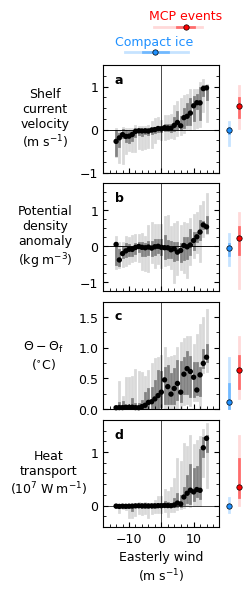

In [22]:
from matplotlib.ticker import MultipleLocator
        
fig, axs = plt.subplots(4,1,figsize=(1.5,6))

# axs = AXS.ravel()

# x values
#==================================
# X = data['easterly'] #shelf_dma_16bf #* units('m/s').to('km/day').magnitude
cbin_edges = np.arange(-20,20.1,1)
#==================================
cbin_width = np.diff(cbin_edges)[0]
cbin_centers = cbin_edges[:-1] + cbin_width



open_ = (data['length'] > 0) #& (data['event_day']<7) #& (data['final_day']==False)
comp_ = (data['length'] == 0)& data['outside_event']

for ax in axs.ravel():
    ax.set_xlim(-18,18)
    
    

x1 = 21
x2 = 24

LW = 2.

#  data['iht'].magnitude/1e8

# data['dT_sfc']

# stress = (np.sign(data['easterly_21bf']) * data['easterly_21bf']**2)/12

stress = (np.sign(data['easterly_21bf']) * data['easterly_21bf']**2)/12

# xxxx = [stress,stress,stress,stress]
xxxx = [data['easterly_21bf'], data['easterly_21bf'], data['easterly_21bf'], data['easterly_21bf']]


# 0.01*data['length'], (10e-8)*data['iht'].magnitude,
for ax, XX, YY in zip(axs, 
                      xxxx,
                       [data['shelf_dma'],  data['sig0_dma_anom'], data['dT_dma'], data['iht'].magnitude/1e8 ]):

    ax.axvline(0, c='k', lw=0.5)
    ax.axhline(0, c='k', lw=0.5)
    
    vals = generate_dist(XX, YY, cbin_edges)

    for xx, yymed, yymin, yymax, yyminex, yymaxex in zip(cbin_centers, vals[50], vals[25], vals[75], vals[5], vals[95]):
        ax.scatter([xx],[yymed], marker='o', edgecolor='None',lw=0.6, facecolor='k', s=15, clip_on=False, zorder=100)
        ax.plot([xx,xx],[yymin, yymax], lw=LW, alpha=0.4, c='k', clip_on=False)
        ax.plot([xx,xx],[yyminex, yymaxex], lw=LW, alpha=0.15, c='k', clip_on=False)


    lw = 2
    size = 15
    cond = comp_
    ax.plot([x1,x1],[np.nanpercentile(YY[cond], 25), np.nanpercentile(YY[cond], 75)], lw=lw, alpha=0.5, c='dodgerblue', clip_on=False)
    ax.plot([x1,x1],[np.nanpercentile(YY[cond], 5), np.nanpercentile(YY[cond], 95)], lw=lw, alpha=0.25, c='dodgerblue', clip_on=False)
    ax.scatter(x1, np.nanmedian(YY[cond]), s=size,  edgecolor='k',lw=0.5, facecolor='dodgerblue',  clip_on=False, zorder=100)
    
    cond = open_
    ax.plot([x2,x2],[np.nanpercentile(YY[cond], 25), np.nanpercentile(YY[cond], 75)], lw=lw, alpha=0.5, c='r', clip_on=False)
    ax.plot([x2,x2],[np.nanpercentile(YY[cond], 5), np.nanpercentile(YY[cond], 95)], lw=lw, alpha=0.15, c='r', clip_on=False)
    ax.scatter(x2 ,np.nanmedian(YY[cond]), s=size, edgecolor='k',lw=0.5, facecolor='r', clip_on=False, zorder=100)

    
for ax in axs[:2]:
    ax.axhline(0, lw=0.5, c='k', zorder=-5)

ax = axs[0]
y1 = 1.8
y2 = 2.4
YY = data['easterly']
ax.plot([np.nanpercentile(YY[comp_], 25), np.nanpercentile(YY[comp_], 75)], [y1,y1],lw=lw, alpha=0.5, c='dodgerblue', clip_on=False)
ax.plot([np.nanpercentile(YY[comp_], 5), np.nanpercentile(YY[comp_], 95)],[y1,y1], lw=lw, alpha=0.25, c='dodgerblue', clip_on=False)
ax.scatter( np.nanmedian(YY[comp_]), y1,  s=size,  edgecolor='k',lw=0.5, facecolor='dodgerblue',  clip_on=False, zorder=100)


ax.plot([np.nanpercentile(YY[open_], 25), np.nanpercentile(YY[open_], 75)],[y2,y2], lw=lw, alpha=0.5, c='r', clip_on=False)
ax.plot([np.nanpercentile(YY[open_], 5), np.nanpercentile(YY[open_], 95)],[y2,y2], lw=lw, alpha=0.15, c='r', clip_on=False)
ax.scatter(np.nanmedian(YY[open_]), y2,  s=size,  edgecolor='k',lw=0.5, facecolor='r',  clip_on=False, zorder=100)

ax.text(np.nanmedian(YY[open_]), y2+0.1, 'MCP events', ha='center', va='bottom', c='r')
ax.text(np.nanmedian(YY[comp_]), y1+0.1, 'Compact ice', ha='center', va='bottom', c='dodgerblue')



dist_color = [0.75]*3# 'k'

# current
#------
ax = axs[0]
ax.set_ylim(-1.,1.5)#
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_ylabel('Shelf\ncurrent\nvelocity\n$(\mathrm{m\;s^{-1}})$', rotation=0, labelpad=25, va='center')

# SIGMA
#------
ax = axs[1]
ax.set_ylim(-1.25,1.75)#
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_ylabel('Potential\ndensity\nanomaly\n$(\mathrm{kg\;m^{-3}})$', rotation=0, labelpad=25, va='center')


# TEMP
#-----
ax = axs[2]
ax.set_ylim(0,1.75)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
# ax.set_ylabel('Temperature\nabove\nfreezing\n($\mathrm{^{\circ}C})$', rotation=0, labelpad=30, va='center')
ax.set_ylabel('$\mathrm{\\Theta - \\Theta_{f}}$\n$(\mathrm{^{\circ}C})$', rotation=0, labelpad=25, va='center')
# $\mathrm{\\Theta - \\Theta_{f}}$\n$

# Heat
#-----
ax = axs[3]
ax.set_ylim(-0.4,1.6)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_ylabel('Heat\ntransport\n$(\mathrm{10^{7}\;W\;m^{-1}})$', rotation=0, labelpad=30, va='center')

for ax in axs[:-1]:
    ax.set_xticklabels([])

for ax in axs:
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    
    # Enable right-side ticks
    ax.yaxis.set_ticks_position('both')    # show ticks on both left and right
    ax.tick_params(axis='y', which='both',  direction='in')  # point y-ticks inward
    ax.tick_params(axis='x', which='both',  direction='in')  # optional: make x-ticks inward too
    
ax.set_xlabel('Easterly wind\n$(\mathrm{m\;s^{-1}})$')

plt.subplots_adjust(hspace=0.1)

for aa, ax in enumerate(axs):
    ax.text(0.1,0.925, f"{chr(97+aa)}", va='top',  weight='bold', transform = ax.transAxes)
    
SAVE(fig, '../figures/results/Fig10.png')

# fig.savefig('/Users/mackenziejewell/Desktop/Fig09.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [13]:
np.nanmean(data['ihc'][data['length'] > 0])

<Quantity(96820764.9, 'joule / meter ** 2')>

In [32]:
data.keys()

dict_keys(['time', 'iht', 'ihc', 'easterly', 'easterly_21bf', 'northerly', 'northerly_21bf', 'windspeed', 'windspeed_21bf', 'windangle', 'windangle_21bf', 'dT_dma', 'dT_dma_lp', 'dT_dma_16bf', 'dT_sfc', 'dT_sfc_lp', 'dT_sfc_16bf', 'sig0_dma', 'sig0_dma_lp', 'sig0_dma_16bf', 'sig0_sfc', 'sig0_sfc_lp', 'sig0_sfc_16bf', 'shelf_dma', 'shelf_dma_lp', 'shelf_dma_16bf', 'shelf_sfc', 'shelf_sfc_lp', 'shelf_sfc_16bf', 'Sp_dma', 'Sp_dma_lp', 'Sp_dma_16bf', 'Sp_sfc', 'Sp_sfc_lp', 'Sp_sfc_16bf', 'sig0_sfc_anom', 'sig0_dma_anom', 'length', 'extent', 'event_day', 'day_before_event', 'day_after_event', 'final_day', 'outside_event'])

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


(-20.0, 20.0)

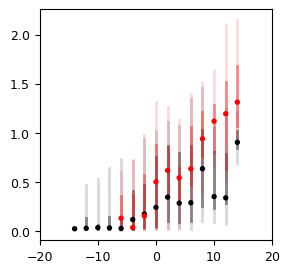

In [31]:
AWevents = (data['time'] > datetime(2017,12,1)) & (data['time'] < datetime(2018,2,1))
                                                   
fig, ax = plt.subplots(figsize=(3,3))

XX = data['easterly_21bf'][AWevents==False]
YY = data['ihc'][AWevents==False].magnitude/1e8


cbin_edges = np.arange(-20,20,2)
cbin_width = np.diff(cbin_edges)[0]
cbin_centers = cbin_edges[:-1] + cbin_width

vals = generate_dist(XX, YY, cbin_edges)

for xx, yymed, yymin, yymax, yyminex, yymaxex in zip(cbin_centers, vals[50], vals[25], vals[75], vals[5], vals[95]):
        ax.scatter([xx],[yymed], marker='o', edgecolor='None',lw=0.6, facecolor='k', s=15, clip_on=False, zorder=100)
        ax.plot([xx,xx],[yymin, yymax], lw=LW, alpha=0.4, c='k', clip_on=False)
        ax.plot([xx,xx],[yyminex, yymaxex], lw=LW, alpha=0.15, c='k', clip_on=False)
        
        
XX = data['easterly_21bf'][AWevents==True]
YY = data['ihc'][AWevents==True].magnitude/1e8

vals = generate_dist(XX, YY, cbin_edges)

for xx, yymed, yymin, yymax, yyminex, yymaxex in zip(cbin_centers, vals[50], vals[25], vals[75], vals[5], vals[95]):
        ax.scatter([xx],[yymed], marker='o', edgecolor='None',lw=0.6, facecolor='r', s=15, clip_on=False, zorder=100)
        ax.plot([xx,xx],[yymin, yymax], lw=LW, alpha=0.4, c='r', clip_on=False)
        ax.plot([xx,xx],[yyminex, yymaxex], lw=LW, alpha=0.15, c='r', clip_on=False)

ax.set_xlim(-20,20)

In [147]:
data['ihc']

Magnitude,[105103139.73903504 105737291.20449054 106272795.53693506 ... 49494143.337870054 49331439.259941414 48828890.94262738]
Units,joule/meter2


In [63]:
wind_cond = data['easterly_21bf']>7
positive = data['iht'] > 0

np.nansum(data['iht'][positive&wind_cond]) / np.nansum(data['iht'][positive])

<Quantity(0.719737248, 'dimensionless')>

In [14]:
daily_mean_poly = data['length'].reshape(-1,24).mean(axis=1)
daily_mean_shelf = data['shelf_dma'].reshape(-1,24).mean(axis=1)
daily_mean_IHT = data['iht'].reshape(-1,24).mean(axis=1)
daily_mean_IHC = data['ihc'].reshape(-1,24).mean(axis=1)

<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:84: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:84: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_20887/3026614572.py:41: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Shelf current velocity\n($\mathrm{km\;{d}^{-1}}$)")
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_20887/3026614572.py:71: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat content\n($\mathrm{10^{8}\;J\;{m}^{-2}}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_20887/3026614572.py:84: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat transport\n($\mathrm{10^{7}\;W\;{m}^{-1}}$)')


LinregressResult(slope=0.8282535659130398, intercept=4.588201127660545, rvalue=0.6890158094558689, pvalue=7.568596944091328e-44, stderr=0.05029901878999967, intercept_stderr=1.456099370383046)
LinregressResult(slope=7.349123646680574, intercept=3.5231871832629427, rvalue=0.713923240920193, pvalue=2.3937848323490227e-48, stderr=0.4161600425982619, intercept_stderr=1.4231860813915849)


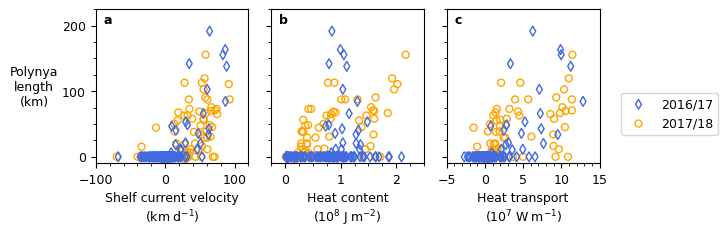

In [15]:


fig, axs = plt.subplots(1,3,figsize=(6.5,2))

# ax.scatter(cum_pack_drifts, all_extents[all_extents>0][::24]/50)

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24], s=10, c='k', alpha=1)



m1_kwargs = {'edgecolor' : 'royalblue', 'marker' : 'd', 'facecolor':'None',  's':25, 'alpha':1, 'zorder':1}

m2_kwargs = {'edgecolor' : 'orange', 'marker' : 'o',  'facecolor':'None', 's':25, 'alpha':1,'zorder':0}


mo_kwargs = {'edgecolor' : 'k', 'marker' : 'o', 'facecolor':'r',  's':30, 'alpha':1,}
lo_kwargs = {'c':'r', 'lw':1, 'alpha':1,}
mc_kwargs = {'edgecolor' : 'k', 'marker' : 'o', 'facecolor':'dodgerblue',  's':30, 'alpha':1,}
lc_kwargs = {'c':'dodgerblue', 'lw':1, 'alpha':1,}

# Y1 = (all_years[::24]==2017)
# Y2 = (all_years[::24]==2018)

# #-------------------------
# ax = axs[0]
# ax.set_xlabel("Easterly wind\n($\mathrm{m\;{s}^{-1}}$)")
# ax.set_ylabel('Polynya\nlength\n(km)', rotation=0, labelpad=20, va='center')
# ax.xaxis.set_major_locator(MultipleLocator(10))
# ax.xaxis.set_minor_locator(MultipleLocator(2))
# ax.set_xlim(-0,20)

# for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

#     daily_mean_wind = data['easterly'][cond].reshape(-1,24).mean(axis=1)
#     daily_mean_poly = data['length'][cond].reshape(-1,24).mean(axis=1)
    
#     ax.scatter(daily_mean_wind, 
#                daily_mean_poly,label=lab, **kw)
    
#-------------------------
ax = axs[0]
ax.set_xlabel("Shelf current velocity\n($\mathrm{km\;{d}^{-1}}$)")
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.set_xlim(-100,120)

# ax.plot([0,100,],[0,100], c='k', zorder=-1)

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    daily_mean_shelf = data['shelf_dma'][cond].reshape(-1,24).mean(axis=1) * units('m/s').to('km/day').magnitude
    daily_mean_poly = data['length'][cond].reshape(-1,24).mean(axis=1)
    
    ax.scatter(daily_mean_shelf, 
               daily_mean_poly,label=lab, **kw)
    
x = data['shelf_dma'].reshape(-1,24).mean(axis=1) * units('m/s').to('km/d').magnitude
y = data['length'].reshape(-1,24).mean(axis=1)
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)
# ax.plot(np.linspace(-5, x.max(),10), resp.slope * np.linspace(-5, x.max(),10) + resp.intercept, c='k', lw=1.5, ls='solid')



#-------------------------

ax = axs[1]
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlim(-0.25,2.5)
ax.set_xlabel('Heat content\n($\mathrm{10^{8}\;J\;{m}^{-2}}$)')

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    daily_mean_IHC = data['ihc'][cond].reshape(-1,24).mean(axis=1)
    daily_mean_poly = data['length'][cond].reshape(-1,24).mean(axis=1)
    
    ax.scatter(daily_mean_IHC.magnitude/1e8, 
               daily_mean_poly,**kw)


#-------------------------
ax = axs[2]
ax.set_xlabel('Heat transport\n($\mathrm{10^{7}\;W\;{m}^{-1}}$)')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlim(-5,15)
for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    daily_mean_IHT = data['iht'][cond].reshape(-1,24).mean(axis=1)
    daily_mean_poly = data['length'][cond].reshape(-1,24).mean(axis=1)
    
    ax.scatter(daily_mean_IHT.to('W/m').magnitude/1e7, 
               daily_mean_poly,label=lab, **kw)
    

x = data['iht'].reshape(-1,24).mean(axis=1).to('W/m').magnitude/1e7
y = data['length'].reshape(-1,24).mean(axis=1)
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)
# ax.plot(np.linspace(-5, x.max(),10), resp.slope * np.linspace(-5, x.max(),10) + resp.intercept, c='k', lw=1.5, ls='solid')



axs[2].legend(bbox_to_anchor=(1.1,0.5))
    
# ax.set_ylabel('Polynya length')

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24]/cum_pack_drifts, s=10, c='k', alpha=1)

# ax.set_ylim(-1,10)

plt.subplots_adjust(wspace=0.15)

axs[0].set_ylabel('Polynya\nlength\n(km)', rotation=0, labelpad=20, va='center')

for ax in axs:
    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(MultipleLocator(25))
    ax.set_ylim(-10,225)
for ax in axs[1:]:
    ax.set_yticklabels([])

for aa, ax in enumerate(axs):
    ax.text(0.05,0.975, f'{chr(aa+97)}',va='top', ha='left', weight='bold', transform=ax.transAxes)

SAVE(fig, '../figures/results/Fig09.png')
# fig.savefig('../figures/results/Fig10.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [74]:
0.85*12

10.2

In [16]:
np.nanmean(data['ihc'][data['length']>0] / (cst['L_i']*cst['rho_i'])).to('cm')

<Quantity(31.6120534, 'centimeter')>

In [17]:
np.nanmean(data['ihc'][data['outside_event']] / (cst['L_i']*cst['rho_i'])).to('cm')

<Quantity(12.001706, 'centimeter')>

In [18]:
np.nanmean(data['ihc'][data['length']>0])/np.nanmean(data['ihc'][data['outside_event']])#/(9*10**7)

<Quantity(2.63396332, 'dimensionless')>

In [19]:
np.nanmean(data['iht'][data['length']>0])/np.nanmean(data['iht'][data['outside_event']])

<Quantity(93.2772749, 'dimensionless')>

In [20]:

convert = cst['L_i'] * cst['rho_i']
((np.nanmean(data['ihc'][data['length']>0])) / convert).to('cm')

<Quantity(31.6120534, 'centimeter')>

In [33]:

shelf_length = 120*units('km').to('m')
convert = cst['L_i'] * cst['rho_i'] * shelf_length
((np.nanstd(data['iht'][data['length']>0])) / convert).to('cm/day')

<Quantity(10.4905694, 'centimeter / day')>

In [35]:

shelf_length = 120*units('km').to('m')
convert = cst['L_i'] * cst['rho_i'] * shelf_length
((np.nanmean(data['iht'][data['outside_event']])) / convert).to('cm/day')

<Quantity(0.127507139, 'centimeter / day')>

In [25]:
np.nanmean(data['iht'][data['outside_event']])

<Quantity(542397.662, 'joule / meter / second')>

In [73]:
8.6/12

0.7166666666666667

In [49]:
total_pos_heat_input = np.sum(data['iht'][data['iht']>0])
event_pos_heat_input = np.sum(data['iht'][(data['iht']>0)&(data['length']>0)])

event_pos_heat_input/total_pos_heat_input

<Quantity(0.771503645, 'dimensionless')>

In [42]:
np.sum((data['length']>0))/len(data['length'])

0.23841059602649006

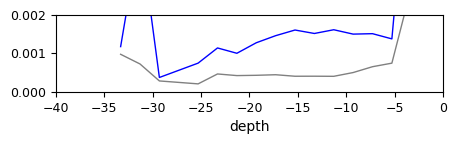

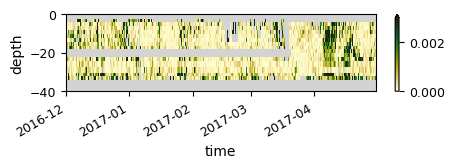

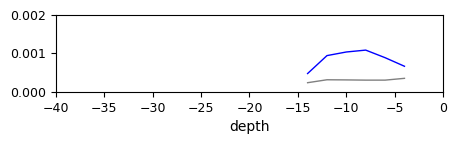

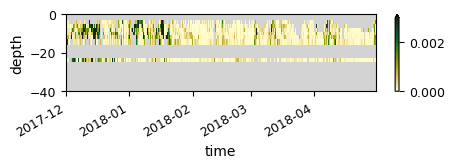

In [563]:
for open_year, time_range, bool_ in zip(open_years, time_ranges, [True, False]):
    
    dsc = xr.open_dataset(main_path + F"M1_hourly_ocean_currents_{open_year}.nc")
    #     dsc = dsc.interpolate_na(dim='depth', method='linear', use_coordinate=True, limit=5)
    #     dsc = dsc.interpolate_na(dim='time', method='linear', use_coordinate=True, limit=24)
    # dsc['shelf'] = vectors.comp_along_theta(dsc.u, dsc.v, 145*units('degree'))
    dsc = dsc.sel(time = time_range)


    # dsc = dsc.interpolate_na(dim='depth', method='linear', use_coordinate=True, limit=5)
    # dsc = dsc.interpolate_na(dim='time', method='linear', use_coordinate=True, limit=24)

    DUDZ = dsc.u.diff('depth')/dsc.depth.diff('depth')
    DVDZ = dsc.v.diff('depth')/dsc.depth.diff('depth')

    sh2 = (DUDZ)**2 + (DVDZ)**2

    fig, ax = plt.subplots(figsize=(5,1))
    ax.set_xlim(-40,0)
    ax.set_ylim(0,0.002)
    
    sh2.sel(time=data['time'][(data['length']>0)&(Y1==bool_)]).mean('time').plot(c='b')
    sh2.sel(time=data['time'][(data['length']==0)&(Y1==bool_)]).mean('time').plot(c='gray')
#     sh2.sel(time=data['time'][(data['length']>0)&(Y1==bool_)]).std('time').plot(c='b')
    
    fig, ax = plt.subplots(figsize=(5,1))
    ax.patch.set_facecolor('lightgray')
#     sh2.plot(norm=mcolors.LogNorm(vmin=0.0003, vmax=0.005), cmap=cmocean.cm.speed)
    sh2.plot(ax = ax, vmin=0.0, vmax=0.003, cmap=cmocean.cm.speed)
    ax.set_ylim(-40,0)

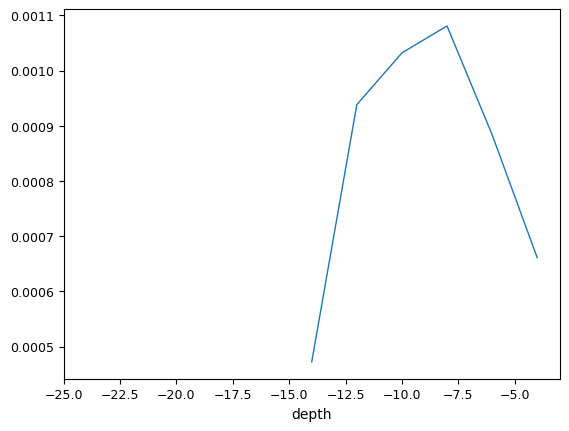

In [552]:
sh2.sel(time=data['time'][(data['length']>0)&(Y1==False)]).mean('time').plot()

In [527]:
open_year

'2017_2018'

In [ ]:
import matplotlib.colors as mcolors

In [ ]:
vmin=0, vmax=0.01, 

In [502]:
dsc

<xarray.Dataset>
Dimensions:  (depth: 10, time: 3624)
Coordinates:
  * depth    (depth) float64 -30.0 -24.0 -22.0 -18.0 ... -10.0 -8.0 -6.0 -4.0
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
Data variables:
    u        (depth, time) float64 -0.4222 -0.4119 -0.4137 ... -0.5501 -0.4883
    v        (depth, time) float64 0.1624 0.1652 0.1773 ... 0.5777 0.5748 0.5873
    shelf    (depth, time) float64 0.439 0.4322 0.4406 ... 0.8077 0.7803 0.7368
Attributes:
    lat:      69.7718
    lon:      -139.2582

array(['2016-12-06', '2016-12-15', '2016-12-18', '2017-01-24',
       '2017-01-27', '2017-02-24', '2017-02-26', '2017-03-28',
       '2017-04-04', '2017-04-05', '2017-04-06', '2017-04-07',
       '2017-04-08', '2017-04-09', '2017-04-10', '2017-04-15',
       '2017-04-16', '2017-04-17', '2017-04-29', '2017-04-30'],
      dtype=object)

In [415]:
data['easterly']

array([1.36343062, 1.00738227, 0.76599014, ..., 5.62870741, 4.56007338,
       3.82553005])

In [414]:
data.keys()

dict_keys(['time', 'iht', 'ihc', 'easterly', 'easterly_21bf', 'windspeed', 'windspeed_21bf', 'windangle', 'windangle_21bf', 'dT_dma', 'dT_dma_lp', 'dT_dma_16bf', 'dT_sfc', 'dT_sfc_lp', 'dT_sfc_16bf', 'sig0_dma', 'sig0_dma_lp', 'sig0_dma_16bf', 'sig0_sfc', 'sig0_sfc_lp', 'sig0_sfc_16bf', 'shelf_dma', 'shelf_dma_lp', 'shelf_dma_16bf', 'shelf_sfc', 'shelf_sfc_lp', 'shelf_sfc_16bf', 'Sp_dma', 'Sp_dma_lp', 'Sp_dma_16bf', 'Sp_sfc', 'Sp_sfc_lp', 'Sp_sfc_16bf', 'sig0_sfc_anom', 'sig0_dma_anom', 'length', 'extent', 'event_day', 'day_before_event', 'day_after_event', 'final_day', 'outside_event'])

In [385]:
data['time'] < datetime(2017,9,1)

array([ True,  True,  True, ..., False, False, False])

In [384]:
Y1

array([ True,  True,  True, ..., False, False, False])

In [381]:
data.keys()

dict_keys(['time', 'iht', 'ihc', 'easterly', 'easterly_21bf', 'windspeed', 'windspeed_21bf', 'windangle', 'windangle_21bf', 'dT_dma', 'dT_dma_lp', 'dT_dma_16bf', 'dT_sfc', 'dT_sfc_lp', 'dT_sfc_16bf', 'sig0_dma', 'sig0_dma_lp', 'sig0_dma_16bf', 'sig0_sfc', 'sig0_sfc_lp', 'sig0_sfc_16bf', 'shelf_dma', 'shelf_dma_lp', 'shelf_dma_16bf', 'shelf_sfc', 'shelf_sfc_lp', 'shelf_sfc_16bf', 'Sp_dma', 'Sp_dma_lp', 'Sp_dma_16bf', 'Sp_sfc', 'Sp_sfc_lp', 'Sp_sfc_16bf', 'sig0_sfc_anom', 'sig0_dma_anom', 'length', 'extent', 'event_day', 'day_before_event', 'day_after_event', 'final_day', 'outside_event'])

In [382]:
data['length']>0

array([False, False, False, ...,  True,  True,  True])

In [383]:
data['time'][data['length']>0]

DatetimeIndex(['2016-12-06 00:00:00', '2016-12-06 01:00:00',
               '2016-12-06 02:00:00', '2016-12-06 03:00:00',
               '2016-12-06 04:00:00', '2016-12-06 05:00:00',
               '2016-12-06 06:00:00', '2016-12-06 07:00:00',
               '2016-12-06 08:00:00', '2016-12-06 09:00:00',
               ...
               '2018-04-30 14:00:00', '2018-04-30 15:00:00',
               '2018-04-30 16:00:00', '2018-04-30 17:00:00',
               '2018-04-30 18:00:00', '2018-04-30 19:00:00',
               '2018-04-30 20:00:00', '2018-04-30 21:00:00',
               '2018-04-30 22:00:00', '2018-04-30 23:00:00'],
              dtype='datetime64[ns]', length=1728, freq=None)

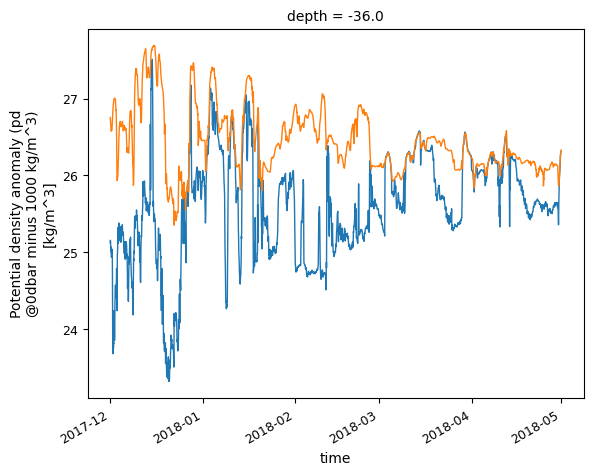

In [356]:
ds['sig0'].sel(depth=ds.depth.max()).plot()
ds['sig0'].sel(depth=ds.depth.min()).plot()

In [30]:
set(data['day_after_event'][comp_])
set(data['day_before_event'][comp_])


{-999.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0}

In [31]:
np.sum(comp_ & (data['outside_event']))/np.sum(comp_)

0.851528384279476

In [1415]:
np.sum(comp_ & (data['outside_event']==True))/np.sum(comp_)

0.851528384279476

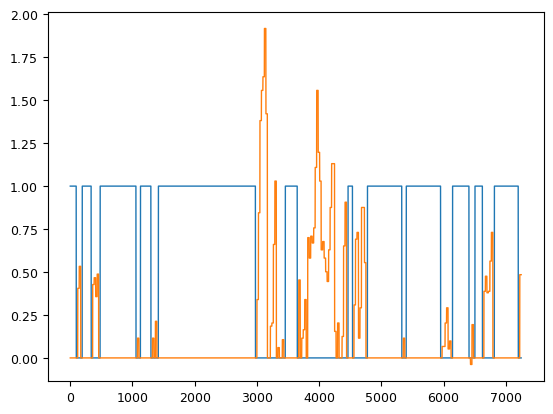

In [32]:
fig, ax = plt.subplots()

plt.plot(data['outside_event'])

# plt.plot(-data['day_before_event'])
plt.plot(data['length']/100)

In [208]:
ds.sig0

<xarray.DataArray 'sig0' (z: 21, time: 3624)>
array([[1026.753374, 1026.730064, 1026.721882, ..., 1026.307373, 1026.300412,
        1026.330971],
       [1026.753374, 1026.730064, 1026.721882, ..., 1026.307373, 1026.300412,
        1026.330971],
       [1026.753374, 1026.730064, 1026.721882, ..., 1026.307373, 1026.300412,
        1026.330971],
       ...,
       [1025.123011, 1025.151088, 1025.153438, ..., 1026.303753, 1026.309055,
        1026.311083],
       [1025.123011, 1025.151088, 1025.153438, ..., 1026.303753, 1026.309055,
        1026.311083],
       [1025.123011, 1025.151088, 1025.153438, ..., 1026.303753, 1026.309055,
        1026.311083]])
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
  * z        (z) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0 0.0
Attributes:
    long_name:  Practical salinity
    units:      psu

In [176]:
print(list(set(df[(df.year==2017)+(df.year==2018)].sequence)))

print(len(list(set(df[(df.year==2017)+(df.year==2018)].sequence))))

[-999, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]
21


In [193]:
df.time[df.sequence==102]

4577    2018-01-09
4578    2018-01-10
4579    2018-01-11
4580    2018-01-12
4581    2018-01-13
4582    2018-01-14
4583    2018-01-15
4584    2018-01-16
Name: time, dtype: object

In [203]:
np.sum(data['length']>0)/24

72.0

In [201]:
np.sum(data['outside_event'])/24

195.0

In [202]:
(len(data['length'])/24)/2

151.0

In [ ]:
data['time']

<>:87: SyntaxWarning: invalid escape sequence '\m'
<>:95: SyntaxWarning: invalid escape sequence '\m'
<>:105: SyntaxWarning: invalid escape sequence '\m'
<>:125: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\m'
<>:95: SyntaxWarning: invalid escape sequence '\m'
<>:105: SyntaxWarning: invalid escape sequence '\m'
<>:125: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21412/662479184.py:87: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Shelf\ncurrent\nvelocity\n$(\mathrm{m\;s^{-1}})$', rotation=0, labelpad=25, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21412/662479184.py:95: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Potential\ndensity\nanomaly\n$(\mathrm{kg\;m^{-3}})$', rotation=0, labelpad=25, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21412/662479184.py:105: SyntaxWarning: invalid escape sequenc

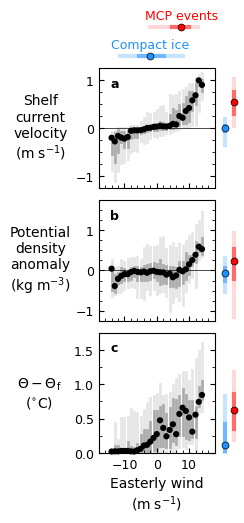

<>:149: SyntaxWarning: invalid escape sequence '\m'
<>:149: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21412/3124185793.py:149: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Easterly wind\n$(\mathrm{m\;s^{-1}})$')


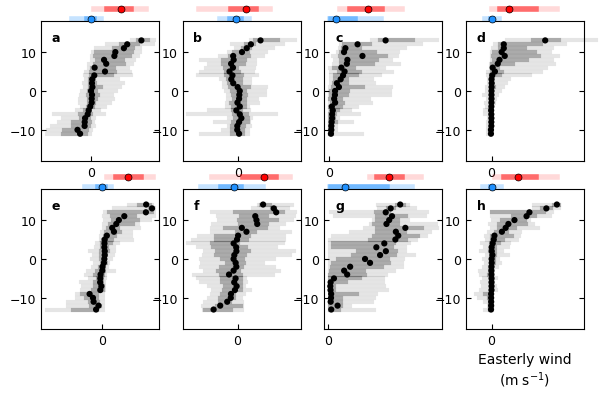

In [819]:
from matplotlib.ticker import MultipleLocator
        
fig, axs = plt.subplots(2,4,figsize=(7,4))

# axs = AXS.ravel()

# x values
#==================================
# X = data['easterly'] #shelf_dma_16bf #* units('m/s').to('km/day').magnitude
cbin_edges = np.arange(-20,20.1,1.)
#==================================
cbin_width = np.diff(cbin_edges)[0]
cbin_centers = cbin_edges[:-1] + cbin_width



open_ = (data['length'] > 0) #& (data['event_day']<7) #& (data['final_day']==False)
comp_ = (data['length'] == 0)& data['outside_event']

for ax in axs.ravel():
    ax.set_ylim(-18,18)
    
    

x1 = 18.5
x2 = 21

LW = 3


# data['dT_sfc']

# 0.01*data['length'], (10e-8)*data['iht'].magnitude,
for ax, XX, YY in zip(axs[0,:], 
                      [data['easterly'], data['easterly_21bf'], data['easterly_21bf'], data['easterly_21bf']],
                       [data['shelf_dma'],  data['sig0_dma_anom'], data['dT_dma'], 10e-9* data['iht'].magnitude]):


    vals = generate_dist(XX[Y2], YY[Y2], cbin_edges)

    for xx, yymed, yymin, yymax, yyminex, yymaxex in zip(cbin_centers, vals[50], vals[25], vals[75], vals[5], vals[95]):
        ax.scatter([yymed],[xx], edgecolor='None',lw=0.5, facecolor='k', s=20, clip_on=False, zorder=100)
        ax.plot([yymin, yymax],[xx,xx], lw=LW, alpha=0.25, c='k', clip_on=False)
        ax.plot([yyminex, yymaxex],[xx,xx], lw=LW, alpha=0.1, c='k', clip_on=False)


    cond = comp_
    ax.plot([np.nanpercentile(YY[cond], 25), np.nanpercentile(YY[cond], 75)],[x1,x1], lw=4, alpha=0.5, c='dodgerblue', clip_on=False)
    ax.plot([np.nanpercentile(YY[cond], 5), np.nanpercentile(YY[cond], 95)],[x1,x1], lw=4, alpha=0.25, c='dodgerblue', clip_on=False)
    ax.scatter(np.nanmedian(YY[cond]),x1, s=25,  edgecolor='k',lw=0.5, facecolor='dodgerblue',  clip_on=False, zorder=100)
    
    cond = open_
    ax.plot([np.nanpercentile(YY[cond], 25), np.nanpercentile(YY[cond], 75)],[x2,x2], lw=4, alpha=0.5, c='r', clip_on=False)
    ax.plot([np.nanpercentile(YY[cond], 5), np.nanpercentile(YY[cond], 95)],[x2,x2], lw=4, alpha=0.15, c='r', clip_on=False)
    ax.scatter(np.nanmedian(YY[cond]),x2 , s=25, edgecolor='k',lw=0.5, facecolor='r', clip_on=False, zorder=100)

    
for ax, XX, YY in zip(axs[1,:], 
                      [data['easterly'], data['easterly_21bf'], data['easterly_21bf'], data['easterly_21bf']],
                       [data['shelf_dma'],  data['sig0_dma_anom'], data['dT_dma'], 10e-9* data['iht'].magnitude]):


    vals = generate_dist(XX[Y1], YY[Y1], cbin_edges)

    for xx, yymed, yymin, yymax, yyminex, yymaxex in zip(cbin_centers, vals[50], vals[25], vals[75], vals[5], vals[95]):
        ax.scatter([yymed],[xx], edgecolor='None',lw=0.5, facecolor='k', s=20, clip_on=False, zorder=100)
        ax.plot([yymin, yymax],[xx,xx], lw=LW, alpha=0.25, c='k', clip_on=False)
        ax.plot([yyminex, yymaxex],[xx,xx], lw=LW, alpha=0.1, c='k', clip_on=False)


    cond = comp_
    ax.plot([np.nanpercentile(YY[cond][Y1[cond]], 25), np.nanpercentile(YY[cond][Y1[cond]], 75)],[x1,x1], lw=4, alpha=0.5, c='dodgerblue', clip_on=False)
    ax.plot([np.nanpercentile(YY[cond][Y1[cond]], 5), np.nanpercentile(YY[cond][Y1[cond]], 95)],[x1,x1], lw=4, alpha=0.25, c='dodgerblue', clip_on=False)
    ax.scatter(np.nanmedian(YY[cond][Y1[cond]]),x1, s=25,  edgecolor='k',lw=0.5, facecolor='dodgerblue',  clip_on=False, zorder=100)
    
    cond = open_
    ax.plot([np.nanpercentile(YY[cond][Y1[cond]], 25), np.nanpercentile(YY[cond][Y1[cond]], 75)],[x2,x2], lw=4, alpha=0.5, c='r', clip_on=False)
    ax.plot([np.nanpercentile(YY[cond][Y1[cond]], 5), np.nanpercentile(YY[cond][Y1[cond]], 95)],[x2,x2], lw=4, alpha=0.15, c='r', clip_on=False)
    ax.scatter(np.nanmedian(YY[cond][Y1[cond]]),x2 , s=25, edgecolor='k',lw=0.5, facecolor='r', clip_on=False, zorder=100)

    
# for ax in axs[:2]:
#     ax.axhline(0, lw=0.5, c='k', zorder=-5)

# ax = axs[0]
# y1 = 1.6
# y2 = 2.2
# YY = data['easterly']
# ax.plot([np.nanpercentile(YY[comp_], 25), np.nanpercentile(YY[comp_], 75)], [y1,y1],lw=5, alpha=0.5, c='dodgerblue', clip_on=False)
# ax.plot([np.nanpercentile(YY[comp_], 5), np.nanpercentile(YY[comp_], 95)],[y1,y1], lw=5, alpha=0.25, c='dodgerblue', clip_on=False)
# ax.scatter( np.nanmedian(YY[comp_]), y1,  s=25,  edgecolor='k',lw=0.5, facecolor='dodgerblue',  clip_on=False, zorder=100)


# ax.plot([np.nanpercentile(YY[open_], 25), np.nanpercentile(YY[open_], 75)],[y2,y2], lw=5, alpha=0.5, c='r', clip_on=False)
# ax.plot([np.nanpercentile(YY[open_], 5), np.nanpercentile(YY[open_], 95)],[y2,y2], lw=5, alpha=0.15, c='r', clip_on=False)
# ax.scatter(np.nanmedian(YY[open_]), y2,  s=25,  edgecolor='k',lw=0.5, facecolor='r',  clip_on=False, zorder=100)

# ax.text(np.nanmedian(YY[open_]), y2+0.1, 'MCP events', ha='center', va='bottom', c='r')
# ax.text(np.nanmedian(YY[comp_]), y1+0.1, 'Compact ice', ha='center', va='bottom', c='dodgerblue')



# dist_color = [0.75]*3# 'k'

# # current
# #------
# ax = axs[0]
# ax.set_ylim(-1.25,1.25)#
# ax.yaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.25))
# ax.set_ylabel('Shelf\ncurrent\nvelocity\n$(\mathrm{m\;s^{-1}})$', rotation=0, labelpad=25, va='center')

# # SIGMA
# #------
# ax = axs[1]
# ax.set_ylim(-1.25,1.5)#
# ax.yaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.25))
# ax.set_ylabel('Potential\ndensity\nanomaly\n$(\mathrm{kg\;m^{-3}})$', rotation=0, labelpad=25, va='center')


# # TEMP
# #-----
# ax = axs[2]
# ax.set_ylim(0,1.6)
# ax.yaxis.set_major_locator(MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# # ax.set_ylabel('Temperature\nabove\nfreezing\n($\mathrm{^{\circ}C})$', rotation=0, labelpad=30, va='center')
# ax.set_ylabel('$\mathrm{\\Theta - \\Theta_{f}}$\n$(\mathrm{^{\circ}C})$', rotation=0, labelpad=25, va='center')
# # $\mathrm{\\Theta - \\Theta_{f}}$\n$

# Heat
#-----
# ax = axs[3]
# ax.set_ylim(0,1.6)

for ax in axs[:,3]:
    ax.set_xlim(-0.5,1.8)

for ax in axs.ravel():
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    
    # Enable right-side ticks
    ax.yaxis.set_ticks_position('both')    # show ticks on both left and right
    ax.tick_params(axis='y', which='both',  direction='in')  # point y-ticks inward
    ax.tick_params(axis='x', which='both',  direction='in')  # optional: make x-ticks inward too
    
ax.set_xlabel('Easterly wind\n$(\mathrm{m\;s^{-1}})$')


for aa, ax in enumerate(axs.ravel()):
    ax.text(0.09,0.925, f"{chr(97+aa)}", va='top',  weight='bold', transform = ax.transAxes)

fig.savefig('/Users/mackenziejewell/Desktop/Fig12.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [758]:
data.keys()

dict_keys(['time', 'iht', 'ihc', 'easterly', 'easterly_21bf', 'windspeed', 'windspeed_21bf', 'windangle', 'windangle_21bf', 'dT_dma', 'dT_dma_lp', 'dT_dma_16bf', 'dT_sfc', 'dT_sfc_lp', 'dT_sfc_16bf', 'sig0_dma', 'sig0_dma_lp', 'sig0_dma_16bf', 'sig0_sfc', 'sig0_sfc_lp', 'sig0_sfc_16bf', 'shelf_dma', 'shelf_dma_lp', 'shelf_dma_16bf', 'shelf_sfc', 'shelf_sfc_lp', 'shelf_sfc_16bf', 'Sp_dma', 'Sp_dma_lp', 'Sp_dma_16bf', 'Sp_sfc', 'Sp_sfc_lp', 'Sp_sfc_16bf', 'sig0_sfc_anom', 'sig0_dma_anom', 'length', 'extent', 'event_day', 'day_before_event', 'day_after_event', 'final_day', 'outside_event'])

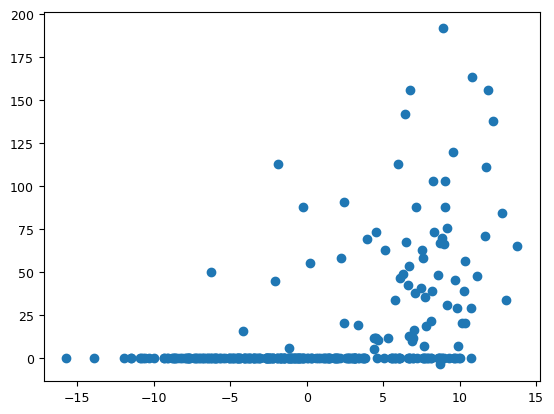

In [708]:
plt.scatter(data['easterly'].reshape(-1,24).mean(axis=1), data['length'][::24])

In [710]:
daily_mean_poly = data['length'].reshape(-1,24).mean(axis=1)
daily_mean_shelf = data['shelf_dma'].reshape(-1,24).mean(axis=1)
daily_mean_IHT = data['iht'].reshape(-1,24).mean(axis=1)
daily_mean_IHC = data['ihc'].reshape(-1,24).mean(axis=1)

<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:84: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:84: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21412/1445369024.py:41: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Shelf current velocity\n($\mathrm{km\;{d}^{-1}}$)")
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21412/1445369024.py:71: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat content\n($\mathrm{10^{8}\;J\;{m}^{-2}}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21412/1445369024.py:84: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat transport\n($\mathrm{10^{7}\;W\;{m}^{-1}}$)')


LinregressResult(slope=0.8282535659130398, intercept=4.588201127660545, rvalue=0.6890158094558689, pvalue=7.568596944091328e-44, stderr=0.05029901878999967, intercept_stderr=1.456099370383046)
LinregressResult(slope=7.286065451027394, intercept=3.5337029919271163, rvalue=0.7133459719843301, pvalue=3.081822897767009e-48, stderr=0.4132699102610239, intercept_stderr=1.4243288544894424)


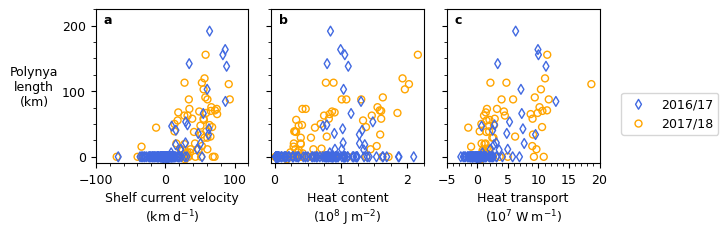

In [1184]:
daily_mean_poly = data['length'].reshape(-1,24).mean(axis=1)
daily_mean_shelf = data['shelf_dma'].reshape(-1,24).mean(axis=1)
daily_mean_IHT = data['iht'].reshape(-1,24).mean(axis=1)
daily_mean_IHC = data['ihc'].reshape(-1,24).mean(axis=1)

fig, axs = plt.subplots(1,3,figsize=(6.5,2))

# ax.scatter(cum_pack_drifts, all_extents[all_extents>0][::24]/50)

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24], s=10, c='k', alpha=1)



m1_kwargs = {'edgecolor' : 'royalblue', 'marker' : 'd', 'facecolor':'None',  's':25, 'alpha':1, 'zorder':1}

m2_kwargs = {'edgecolor' : 'orange', 'marker' : 'o',  'facecolor':'None', 's':25, 'alpha':1,'zorder':0}


mo_kwargs = {'edgecolor' : 'k', 'marker' : 'o', 'facecolor':'r',  's':30, 'alpha':1,}
lo_kwargs = {'c':'r', 'lw':1, 'alpha':1,}
mc_kwargs = {'edgecolor' : 'k', 'marker' : 'o', 'facecolor':'dodgerblue',  's':30, 'alpha':1,}
lc_kwargs = {'c':'dodgerblue', 'lw':1, 'alpha':1,}

# Y1 = (all_years[::24]==2017)
# Y2 = (all_years[::24]==2018)

# #-------------------------
# ax = axs[0]
# ax.set_xlabel("Easterly wind\n($\mathrm{m\;{s}^{-1}}$)")
# ax.set_ylabel('Polynya\nlength\n(km)', rotation=0, labelpad=20, va='center')
# ax.xaxis.set_major_locator(MultipleLocator(10))
# ax.xaxis.set_minor_locator(MultipleLocator(2))
# ax.set_xlim(-0,20)

# for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

#     daily_mean_wind = data['easterly'][cond].reshape(-1,24).mean(axis=1)
#     daily_mean_poly = data['length'][cond].reshape(-1,24).mean(axis=1)
    
#     ax.scatter(daily_mean_wind, 
#                daily_mean_poly,label=lab, **kw)
    
#-------------------------
ax = axs[0]
ax.set_xlabel("Shelf current velocity\n($\mathrm{km\;{d}^{-1}}$)")
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.set_xlim(-100,120)

# ax.plot([0,100,],[0,100], c='k', zorder=-1)

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    daily_mean_shelf = data['shelf_dma'][cond].reshape(-1,24).mean(axis=1) * units('m/s').to('km/day').magnitude
    daily_mean_poly = data['length'][cond].reshape(-1,24).mean(axis=1)
    
    ax.scatter(daily_mean_shelf, 
               daily_mean_poly,label=lab, **kw)
    
x = data['shelf_dma'].reshape(-1,24).mean(axis=1) * units('m/s').to('km/d').magnitude
y = data['length'].reshape(-1,24).mean(axis=1)
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)
# ax.plot(np.linspace(-5, x.max(),10), resp.slope * np.linspace(-5, x.max(),10) + resp.intercept, c='k', lw=1.5, ls='solid')



#-------------------------

ax = axs[1]
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlim(-0.05,2.25)
ax.set_xlabel('Heat content\n($\mathrm{10^{8}\;J\;{m}^{-2}}$)')

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    daily_mean_IHC = data['ihc'][cond].reshape(-1,24).mean(axis=1)
    daily_mean_poly = data['length'][cond].reshape(-1,24).mean(axis=1)
    
    ax.scatter(daily_mean_IHC.magnitude/1e8, 
               daily_mean_poly,**kw)


#-------------------------
ax = axs[2]
ax.set_xlabel('Heat transport\n($\mathrm{10^{7}\;W\;{m}^{-1}}$)')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlim(-5,20)
for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    daily_mean_IHT = data['iht'][cond].reshape(-1,24).mean(axis=1)
    daily_mean_poly = data['length'][cond].reshape(-1,24).mean(axis=1)
    
    ax.scatter(daily_mean_IHT.to('W/m').magnitude/1e7, 
               daily_mean_poly,label=lab, **kw)
    

x = data['iht'].reshape(-1,24).mean(axis=1).to('W/m').magnitude/1e7
y = data['length'].reshape(-1,24).mean(axis=1)
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)
# ax.plot(np.linspace(-5, x.max(),10), resp.slope * np.linspace(-5, x.max(),10) + resp.intercept, c='k', lw=1.5, ls='solid')



axs[2].legend(bbox_to_anchor=(1.1,0.5))
    
# ax.set_ylabel('Polynya length')

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24]/cum_pack_drifts, s=10, c='k', alpha=1)

# ax.set_ylim(-1,10)

plt.subplots_adjust(wspace=0.15)

axs[0].set_ylabel('Polynya\nlength\n(km)', rotation=0, labelpad=20, va='center')

for ax in axs:
    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(MultipleLocator(25))
    ax.set_ylim(-10,225)
for ax in axs[1:]:
    ax.set_yticklabels([])

for aa, ax in enumerate(axs):
    ax.text(0.05,0.975, f'{chr(aa+97)}',va='top', ha='left', weight='bold', transform=ax.transAxes)

fig.savefig('../figures/results/Fig10.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [1187]:
df[years_cond]

NameError: name 'years_cond' is not defined

In [ ]:
years_cond = (df.year==2017) + (df.year==2018)

In [ ]:
df[years_cond]

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21412/3706324775.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat transport\n($\mathrm{10^{7}\;W\;{m}^{-1}}$)')


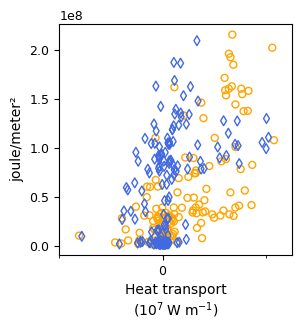

In [1056]:
fig, ax = plt.subplots(figsize=(3,3))


ax.set_xlabel('Heat transport\n($\mathrm{10^{7}\;W\;{m}^{-1}}$)')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlim(-1,1.25)
for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    daily_mean_sheld = data['shelf_dma'][cond].reshape(-1,24).mean(axis=1)
    daily_mean_IHc = data['ihc'][cond].reshape(-1,24).mean(axis=1)

    ax.scatter(daily_mean_sheld, 
               daily_mean_IHc,label=lab, **kw)

In [1046]:
0.50942241511459**2

0.25951119702118164

In [1042]:
0.7133459719843**2

0.5088624757462258

In [1032]:
compc_heat = np.sum(data['iht'][(data['outside_event'])&(data['iht']>0)])
event_heat = np.sum(data['iht'][(data['length']>0)&(data['iht']>0)])
total_heat = np.sum(data['iht'][(data['iht']>0)])
compc_heat/total_heat

<Quantity(0.113626374, 'dimensionless')>

In [1023]:
np.sum(data['iht'][(data['length']>0)&(data['iht']>0)])

<Quantity(8.87729209e+10, 'joule / meter / second')>

In [1035]:
np.nanmean(data['iht'][data['length']>0]) / np.nanmean(data['iht'][data['outside_event']])

<Quantity(89.9608385, 'dimensionless')>

In [1033]:
np.nanmean(data['iht'][data['outside_event']])/1e5

<Quantity(5.6639659, 'joule / meter / second')>

In [1038]:
(np.nanmean(data['iht'][data['length']>0])/convert).to('cm/day')

<Quantity(11.9781796, 'centimeter / day')>

In [1009]:
np.nanmean(data['iht'][data['length']>0])/1e7

<Quantity(5.09535122, 'joule / meter / second')>

In [ ]:
np.nanmean(data['iht'][data['length']>0]) / np.nanmean(data['iht'][data['outside_event']])

LinregressResult(slope=8.432946123874296e-09, intercept=3.53370299192712, rvalue=0.7133459719843298, pvalue=3.081822897767536e-48, stderr=4.783216553947039e-10, intercept_stderr=1.4243288544894432)
0.5088624757462682


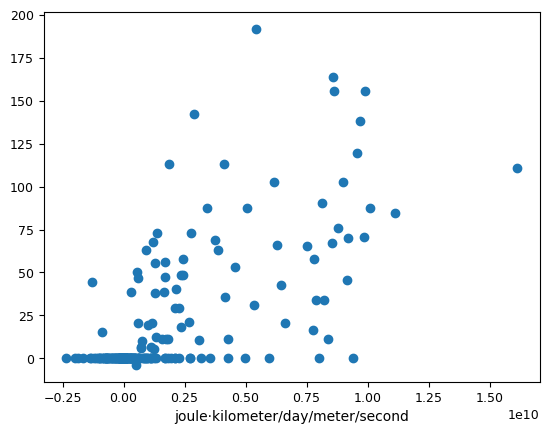

In [996]:
x = data['iht'].reshape(-1,24).mean(axis=1) * units('m/s').to('km/d')
y = data['length'].reshape(-1,24).mean(axis=1)
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)
print(resp.rvalue**2)
plt.scatter(x,y)


In [826]:
1.0098607896268736e-08 / 7.44e-09

1.3573397710038624

In [ ]:
mask = np.isfinite(x) & np.isfinite(y)
resp = stats.linregress(x[mask], y[mask])
print(resp)


In [ ]:
# hi = plotter.quick_hist(data['easterly'][comp_], bin_edges=np.arange(-20,20.1,1))
# ax.bar(hi['centers'], 5*hi['prob'], bottom = ax.get_ylim()[1], width=hi['w'], color='dodgerblue', alpha=0.5,clip_on=False)

# hi = plotter.quick_hist(data['easterly'][open_], bin_edges=np.arange(-20,20.1,1))
# ax.bar(hi['centers'], 5*hi['prob'], bottom = ax.get_ylim()[1], width=hi['w'], color='r', alpha=0.5,clip_on=False)

# hi = plotter.quick_hist(data['shelf_dma'], bin_edges=np.linspace(*ax.get_ylim(),50))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color=dist_color, clip_on=False)

# hi = plotter.quick_hist(data['shelf_dma'][comp_], bin_edges=np.linspace(*ax.get_ylim(),40))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color='dodgerblue', alpha=0.5,clip_on=False)

# hi = plotter.quick_hist(data['shelf_dma'][open_], bin_edges=np.linspace(*ax.get_ylim(),40))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color='r', alpha=0.5,clip_on=False)


# hi = plotter.quick_hist(data['sig0_dma_anom'][comp_], bin_edges=np.linspace(*ax.get_ylim(),40))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color='dodgerblue', alpha=0.5,clip_on=False)

# hi = plotter.quick_hist(data['sig0_dma_anom'][open_], bin_edges=np.linspace(*ax.get_ylim(),40))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color='r', alpha=0.5,clip_on=False)

# ax.stairs(values=ax.get_xlim()[1]+60*hi['prob'],  edges=hi['edges'], 
#           orientation='horizontal', clip_on=False, fill=False, color='k')
# hi = plotter.quick_hist(data['sig0_sfc_anom'][open_], bin_edges=np.linspace(*ax.get_ylim(),30))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color='r', alpha=0.5, clip_on=False)

# hi = plotter.quick_hist(data['sig0_sfc_anom'][comp_], bin_edges=np.linspace(*ax.get_ylim(),30))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color='dodgerblue', alpha=0.5, clip_on=False)

# hi = plotter.quick_hist(data['sig0_sfc_anom'][open_], bin_edges=np.linspace(*ax.get_ylim(),30))
# hic = plotter.quick_hist(data['sig0_sfc_anom'][comp_], bin_edges=np.linspace(*ax.get_ylim(),30))

# ax.barh(hi['centers'],  (np.sum(open_)/len(open_))*60*hi['prob'], 
#         left = ax.get_xlim()[1] + (np.sum(comp_)/len(comp_))*60*hic['prob'], height=hi['w'], color='r', alpha=0.5, clip_on=False)
# ax.barh(hic['centers'],  (np.sum(comp_)/len(comp_))*60*hic['prob'], left = ax.get_xlim()[1], height=hic['w'], color='dodgerblue', alpha=0.5, clip_on=False)


# hi = plotter.quick_hist(data['dT_dma'][comp_], bin_edges=np.linspace(*ax.get_ylim(),50))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color='dodgerblue', alpha=0.5,clip_on=False)

# hi = plotter.quick_hist(data['dT_dma'][open_], bin_edges=np.linspace(*ax.get_ylim(),50))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color='r', alpha=0.5,clip_on=False)



# hi = plotter.quick_hist(data['dT_dma'], bin_edges=np.linspace(*ax.get_ylim(),45))
# ax.barh(hi['centers'],  60*hi['prob'], left = ax.get_xlim()[1], height=hi['w'], color=dist_color, clip_on=False)
# ax.stairs(values=ax.get_xlim()[1]+60*hi['prob'],  edges=hi['edges'], 
#           orientation='horizontal', clip_on=False, fill=False, color='k')

# hi = plotter.quick_hist(data['dT_sfc'][open_], bin_edges=np.linspace(*ax.get_ylim(),30))
# hic = plotter.quick_hist(data['dT_sfc'][comp_], bin_edges=np.linspace(*ax.get_ylim(),30))

# ax.barh(hi['centers'],  (np.sum(open_)/len(open_))*60*hi['prob'], 
#         left = ax.get_xlim()[1] + (np.sum(comp_)/len(comp_))*60*hic['prob'], height=hi['w'], color='r', alpha=0.5, clip_on=False)
# ax.barh(hic['centers'],  (np.sum(comp_)/len(comp_))*60*hic['prob'], left = ax.get_xlim()[1], height=hic['w'], color='dodgerblue', alpha=0.5, clip_on=False)


In [635]:
data['sig0_dma_anom'][data['easterly']>7]

array([-0.00083995,  0.01686369,  0.02975505, ...,  0.28877606,
        0.31655556,  0.33675234])

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  14.,   6.,  12.,  11.,  20.,  31.,  31.,
        107.,  71.,  59.,  50.,  41.,  20.,   8.,  21.,  17.,  12.,  13.,
          0.,   1.,   4.,   9.,   2.,   0.]),
 array([-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
        -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
        -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
        -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
         1.77635684e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
         4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
         1.20000000e+00,  1.30000000e+00,  1.40000000e+00,  1.50000000e+00,
         1.60000000e+00,  1.70000000e+00,  1.800

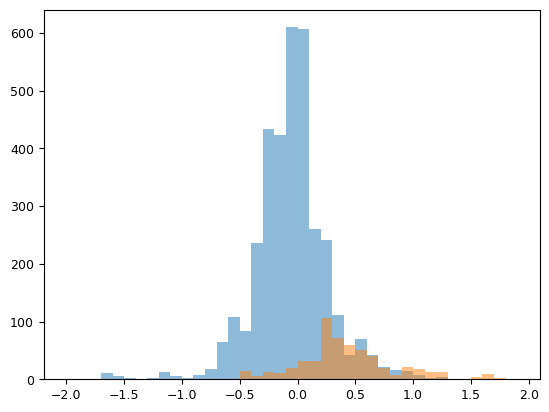

In [660]:
plt.hist(data['sig0_dma_anom'][data['easterly_21bf']<0], bins=np.arange(-2,2,0.1), alpha=0.5)
plt.hist(data['sig0_dma_anom'][data['easterly_21bf']>10], bins=np.arange(-2,2,0.1), alpha=0.5)

In [656]:
np.nanmean(data['sig0_dma_anom'][data['easterly']>12])

0.23437175840290975

In [661]:
np.nanmean(data['sig0_dma_anom'][data['easterly_21bf']<7])

-0.0661392521579228

In [663]:
np.nanmean(data['sig0_sfc_anom'][data['easterly_21bf']>7])

0.18183331674174188

In [653]:
np.nanmean(data['sig0_sfc_anom'][data['easterly']<0])

-0.010194174857679273

In [118]:
around_event = open_ + ((data['outside_event']==False) & (data['length'] == 0))

In [120]:
np.sum(around_event)/24

106.0

In [121]:
len(around_event)/24

302.0

In [117]:
np.sum(open_ + ((data['outside_event']==False) & (data['length'] == 0)))

2544

In [107]:
np.sum(open_)/len(open_)

0.23841059602649006

In [71]:
np.nansum(data['shelf_dma'][data['shelf_dma']>0])

1286.5841380013721

In [72]:
np.nansum(data['shelf_dma'][(data['shelf_dma']>0)&comp_])

197.21491537717753

In [119]:
np.nansum(data['shelf_dma'][(data['shelf_dma']>0)&around_event])

1081.3755088150788

In [123]:
1081.3755088150788/1286.5841380013721

0.8405011976091419

In [74]:
924.6261412159586/1286.5841380013721

0.7186674496487322

In [69]:
np.nanmean(data['shelf_dma'][comp_])# * units('m/s').to('km/day')

-0.026604663964705

In [70]:
np.nanstd(data['shelf_dma'][comp_])

0.18483936439085571

In [42]:
data['easterly']

array([1.36343062, 1.00738227, 0.76599014, ..., 5.62870741, 4.56007338,
       3.82553005])

In [ ]:
df.u10[year_cond]

In [54]:
np.nanmean(data['easterly'][data['shelf_dma'] > 0.25])

7.181702328058173

In [55]:
np.nanpercentile(data['shelf_dma'], 75)

0.2494484596997501

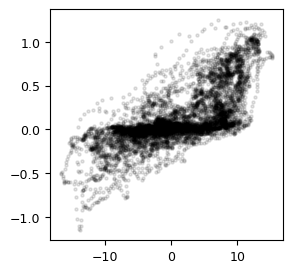

In [50]:
fig, ax = plt.subplots(figsize=(3,3))

year_cond = (df.year==2017) + (df.year==2018)

# ax.scatter(-df.u10[year_cond], df.alongi_km[year_cond], s=5, c='k')

ax.scatter(data['easterly'], data['shelf_dma'], s=5, c='k', alpha=0.1)

# ax.scatter(df.alongi_km[year_cond], data['shelf_dma'][12::24], s=5, c='k')

 
# ax.set_ylim(-40,40, )

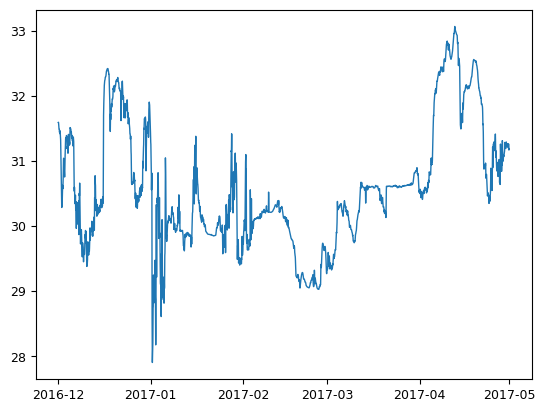

In [1406]:

yr = Y1
plt.plot(data['time'][yr], data['Sp_sfc'][yr])

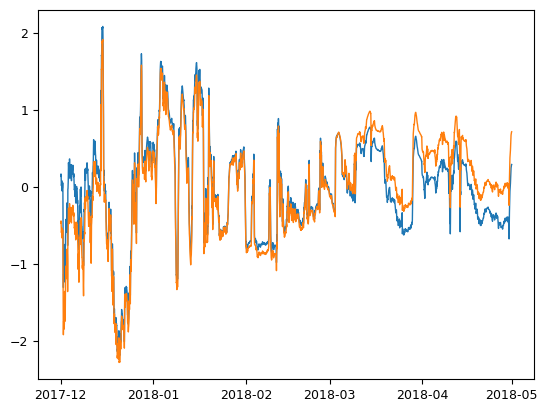

In [1062]:

yr = Y2
plt.plot(data['time'][yr], data['sig0_sfc_anom'][yr])
plt.plot(data['time'][yr], data['sig0_sfc'][yr]-np.nanmean(data['sig0_sfc'][yr]))

<>:104: SyntaxWarning: invalid escape sequence '\m'
<>:113: SyntaxWarning: invalid escape sequence '\m'
<>:122: SyntaxWarning: invalid escape sequence '\m'
<>:129: SyntaxWarning: invalid escape sequence '\m'
<>:104: SyntaxWarning: invalid escape sequence '\m'
<>:113: SyntaxWarning: invalid escape sequence '\m'
<>:122: SyntaxWarning: invalid escape sequence '\m'
<>:129: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_92187/2179408791.py:104: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Shelf\ncurrent\n$(\mathrm{m\;s^{-1}})$', rotation=0, labelpad=30, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_92187/2179408791.py:113: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('SURFACE\nPotential\ndensity\nanomaly\n$(\mathrm{kg\;m^{-3}})$', rotation=0, labelpad=30, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_92187/2179408791.py:122: SyntaxWarning: invalid escape

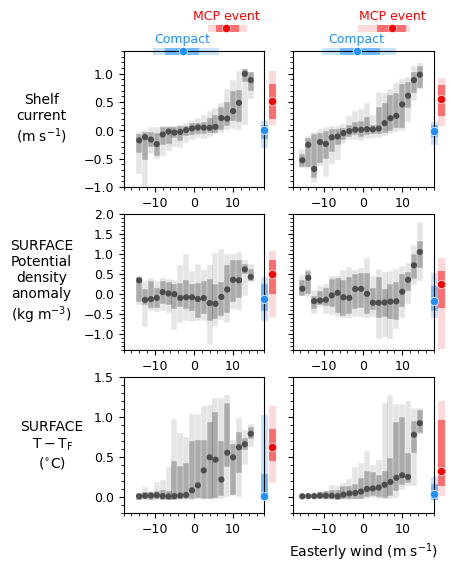

In [992]:
from matplotlib.ticker import MultipleLocator
        
fig, axs = plt.subplots(3,2,figsize=(4,6))

# axs = AXS.ravel()

# x values
#==================================
# X = data['easterly'] #shelf_dma_16bf #* units('m/s').to('km/day').magnitude
cbin_edges = np.arange(-20,20.1,1.5)
#==================================
cbin_width = np.diff(cbin_edges)[0]
cbin_centers = cbin_edges[:-1] + cbin_width



open_ = (data['length'] > 0) #& (data['final_day']==False)
comp_ = (data['length'] == 0) & data['outside_event']

for ax in axs.ravel():
    ax.set_xlim(-18,18)
    
    

x1 = 18
x2 = 20

LW = 4


# data['dT_sfc']

# 0.01*data['length'], (10e-8)*data['iht'].magnitude,
for ax, XX, YY in zip(axs[:,0], 
                      [data['easterly'][Y1], data['easterly_21bf'][Y1], data['easterly_21bf'][Y1]],
                       [data['shelf_dma'][Y1],  data['sig0_sfc_anom'][Y1], data['dT_sfc'][Y1]]):


    vals = generate_dist(XX, YY, cbin_edges)

    for xx, yymed, yymin, yymax, yyminex, yymaxex in zip(cbin_centers, vals[50], vals[25], vals[75], vals[10], vals[90]):
        ax.scatter([xx],[yymed], edgecolor='None',lw=0.5, facecolor=[0.3]*3, s=20, clip_on=False, zorder=100)
        ax.plot([xx,xx],[yymin, yymax], lw=LW, alpha=0.25, c='k', clip_on=False)
        ax.plot([xx,xx],[yyminex, yymaxex], lw=LW, alpha=0.1, c='k', clip_on=False)


    cond = comp_[Y1]
    ax.plot([x1,x1],[np.nanpercentile(YY[cond], 25), np.nanpercentile(YY[cond], 75)], lw=5, alpha=0.5, c='dodgerblue', clip_on=False)
    ax.plot([x1,x1],[np.nanpercentile(YY[cond], 10), np.nanpercentile(YY[cond], 90)], lw=5, alpha=0.25, c='dodgerblue', clip_on=False)
    ax.scatter(x1, np.nanmedian(YY[cond]),  edgecolor='white',lw=0.5, facecolor='dodgerblue',  clip_on=False, zorder=100)
    
    cond = open_[Y1]
    ax.plot([x2,x2],[np.nanpercentile(YY[cond], 25), np.nanpercentile(YY[cond], 75)], lw=5, alpha=0.5, c='r', clip_on=False)
    ax.plot([x2,x2],[np.nanpercentile(YY[cond], 10), np.nanpercentile(YY[cond], 90)], lw=5, alpha=0.15, c='r', clip_on=False)
    ax.scatter(x2 ,np.nanmedian(YY[cond]), edgecolor='white',lw=0.5, facecolor='r', clip_on=False, zorder=100)

for ax, XX, YY in zip(axs[:,1], 
                      [data['easterly'][Y2], data['easterly_21bf'][Y2], data['easterly_21bf'][Y2]],
                       [data['shelf_dma'][Y2],  data['sig0_sfc_anom'][Y2], data['dT_sfc'][Y2]]):


    vals = generate_dist(XX, YY, cbin_edges)

    for xx, yymed, yymin, yymax, yyminex, yymaxex in zip(cbin_centers, vals[50], vals[25], vals[75], vals[10], vals[90]):
        ax.scatter([xx],[yymed], edgecolor='None',lw=0.5, facecolor=[0.3]*3, s=20, clip_on=False, zorder=100)
        ax.plot([xx,xx],[yymin, yymax], lw=LW, alpha=0.25, c='k', clip_on=False)
        ax.plot([xx,xx],[yyminex, yymaxex], lw=LW, alpha=0.1, c='k', clip_on=False)


    cond = comp_[Y2]
    ax.plot([x1,x1],[np.nanpercentile(YY[cond], 25), np.nanpercentile(YY[cond], 75)], lw=5, alpha=0.5, c='dodgerblue', clip_on=False)
    ax.plot([x1,x1],[np.nanpercentile(YY[cond], 10), np.nanpercentile(YY[cond], 90)], lw=5, alpha=0.25, c='dodgerblue', clip_on=False)
    ax.scatter(x1, np.nanmedian(YY[cond]),  edgecolor='white',lw=0.5, facecolor='dodgerblue',  clip_on=False, zorder=100)
    
    cond = open_[Y2]
    ax.plot([x2,x2],[np.nanpercentile(YY[cond], 25), np.nanpercentile(YY[cond], 75)], lw=5, alpha=0.5, c='r', clip_on=False)
    ax.plot([x2,x2],[np.nanpercentile(YY[cond], 10), np.nanpercentile(YY[cond], 90)], lw=5, alpha=0.15, c='r', clip_on=False)
    ax.scatter(x2 ,np.nanmedian(YY[cond]), edgecolor='white',lw=0.5, facecolor='r', clip_on=False, zorder=100)

    
for ax, yr in zip(axs[0,:], [Y1,Y2]):
    y1 = 1.4
    y2 = 1.8
    YY = data['easterly'][yr]
    ax.plot([np.nanpercentile(YY[comp_[yr]], 25), np.nanpercentile(YY[comp_[yr]], 75)], [y1,y1],lw=5, alpha=0.5, c='dodgerblue', clip_on=False)
    ax.plot([np.nanpercentile(YY[comp_[yr]], 10), np.nanpercentile(YY[comp_[yr]], 90)],[y1,y1], lw=5, alpha=0.25, c='dodgerblue', clip_on=False)
    ax.scatter( np.nanmedian(YY[comp_[yr]]), y1,  edgecolor='white',lw=0.5, facecolor='dodgerblue',  clip_on=False, zorder=100)


    ax.plot([np.nanpercentile(YY[open_[yr]], 25), np.nanpercentile(YY[open_[yr]], 75)],[y2,y2], lw=5, alpha=0.5, c='r', clip_on=False)
    ax.plot([np.nanpercentile(YY[open_[yr]], 10), np.nanpercentile(YY[open_[yr]], 90)],[y2,y2], lw=5, alpha=0.15, c='r', clip_on=False)
    ax.scatter(np.nanmedian(YY[open_[yr]]), y2, edgecolor='white',lw=0.5, facecolor='r', clip_on=False, zorder=100)

    ax.text(np.nanmedian(YY[open_[yr]]), y2+0.1, 'MCP event', ha='center', va='bottom', c='r')
    ax.text(np.nanmedian(YY[comp_[yr]]), y1+0.1, 'Compact', ha='center', va='bottom', c='dodgerblue')


# current
#------
for ax in axs[0,:][::-1]:
    ax.set_ylim(-1,1.4)#
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylabel('Shelf\ncurrent\n$(\mathrm{m\;s^{-1}})$', rotation=0, labelpad=30, va='center')
axs[0,1].set_yticklabels([])

# SIGMA
#------
for ax in axs[1,:][::-1]:
    ax.set_ylim(-1.4,2)#
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylabel('SURFACE\nPotential\ndensity\nanomaly\n$(\mathrm{kg\;m^{-3}})$', rotation=0, labelpad=30, va='center')
axs[1,1].set_yticklabels([])

# TEMP
#-----
for ax in axs[2,:][::-1]:
    ax.set_ylim(-0.2,1.5)
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylabel('SURFACE\n$\mathrm{T - T_{F}}$\n$(\mathrm{^{\circ}C})$', rotation=0, labelpad=30, va='center')
axs[2,1].set_yticklabels([])

for ax in axs.ravel():
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    
ax.set_xlabel('Easterly wind $(\mathrm{m\;s^{-1}})$')

fig.savefig('/Users/mackenziejewell/Desktop/Fig12.png', dpi=400, pad_inches=0.1, bbox_inches='tight')


In [1000]:
var = 'sig0_sfc_anom'

print(var)
print()
print(f"2016/17:")
print(f"   - open : {np.nanmean(data[var][Y1&open_]):.2f} +- {np.nanstd(data[var][Y1&open_]):.2f}")
print(f"   - comp : {np.nanmean(data[var][Y1&comp_]):.2f} +- {np.nanstd(data[var][Y1&comp_]):.2f}")
print()
print(f"2017/18:")
print(f"   - open : {np.nanmean(data[var][Y2&open_]):.2f} +- {np.nanstd(data[var][Y2&open_]):.2f}")
print(f"   - comp : {np.nanmean(data[var][Y2&comp_]):.2f} +- {np.nanstd(data[var][Y2&comp_]):.2f}")


sig0_sfc_anom

2016/17:
   - open : 0.39 +- 0.53
   - comp : -0.11 +- 0.43

2017/18:
   - open : 0.06 +- 0.79
   - comp : -0.09 +- 0.34


In [983]:
57294488.27/48163482.69

1.189583582208349

In [945]:
daily_shelf = np.nanmean(data['shelf_dma'].reshape(-1, 24), axis=1)
daily_east = np.nanmean(data['easterly_21bf'].reshape(-1, 24), axis=1)
daily_iht = np.nanmean(data['iht'].reshape(-1, 24), axis=1)
daily_ihc = np.nanmean(data['ihc'].reshape(-1, 24), axis=1)
daily_scft = np.nanmean(data['dT_sfc'].reshape(-1, 24), axis=1)
daily_length = np.nanmean(data['length'].reshape(-1, 24), axis=1)


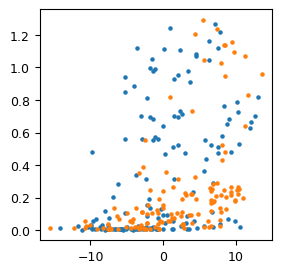

In [959]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.set_xlim(-5,15)

# ax.scatter(data['length'], data['iht'], s=1)

# ax.scatter(daily_east[Y1[12::24]&(data['event_day'][12::24]<8)], daily_length[Y1[12::24]&(data['event_day'][12::24]<8)], s=1)
# ax.scatter(daily_east[Y2[12::24]&(data['event_day'][12::24]<8)], daily_length[Y2[12::24]&(data['event_day'][12::24]<8)], s=1)


ax.scatter(daily_east[Y1[12::24]&(data['event_day'][12::24]<7)], 
           daily_scft[Y1[12::24]&(data['event_day'][12::24]<7)], s=5)
ax.scatter(daily_east[Y2[12::24]&(data['event_day'][12::24]<7)], 
           daily_scft[Y2[12::24]&(data['event_day'][12::24]<7)], s=5)


# ax.scatter(daily_iht[Y1[12::24]], daily_length[Y1[12::24]], s=1)
# ax.scatter(daily_iht[Y2[12::24]], daily_length[Y2[12::24]], s=1)
# ax.scatter(daily_east[data['event_day'][12::24]<8], daily_length[data['event_day'][12::24]<8], s=1)
# ax.scatter(daily_iht, daily_length, s=1)

# ax.scatter(daily_iht, daily_length, s=1)

In [ ]:

ax = axs[3]
ax.set_xlim(-0.1,2.4)
Y = data['ihc'].magnitude/10e7
ax.scatter(Y, X, c='lightgray', s=1)
vals = generate_dist(X, Y, cbin_edges)
plot_dist(ax, vals, cbin_centers, cbin_width, color='k', orientation='h')

ax.scatter(np.nanmedian(Y[comp_]), y1, c='dodgerblue', clip_on=False)
ax.plot([np.nanpercentile(Y[comp_], 25), np.nanpercentile(Y[comp_], 75)], [y1,y1], c='dodgerblue', clip_on=False)
ax.scatter(np.nanmedian(Y[open_]), y2, c='r', clip_on=False)
ax.plot([np.nanpercentile(Y[open_], 25), np.nanpercentile(Y[open_], 75)], [y2,y2], c='r', clip_on=False)

ax = axs[4]
ax.set_xlim(-0.5,2)
Y = data['iht'].magnitude/10e7
ax.scatter(Y, X, c='lightgray', s=1)
vals = generate_dist(X, Y, cbin_edges)
plot_dist(ax, vals, cbin_centers, cbin_width, color='k', orientation='h')

ax.scatter(np.nanmedian(Y[comp_]), y1, c='dodgerblue', clip_on=False)
ax.plot([np.nanpercentile(Y[comp_], 25), np.nanpercentile(Y[comp_], 75)], [y1,y1], c='dodgerblue', clip_on=False)
ax.scatter(np.nanmedian(Y[open_]), y2, c='r', clip_on=False)
ax.plot([np.nanpercentile(Y[open_], 25), np.nanpercentile(Y[open_], 75)], [y2,y2], c='r', clip_on=False)



ax = axs[5]
ax.set_xlim(-5,200)
X = data['easterly']
Y = data['length']
ax.scatter(Y[12::24], X[12::24], c='lightgray', s=1)
vals = generate_dist(X[12::24], Y[12::24], cbin_edges)
# plot_dist(ax, vals, cbin_centers, cbin_width, color='k', orientation='h')

# ax.scatter(np.nanmedian(Y[comp_]), y1, c='dodgerblue', clip_on=False)
# ax.plot([np.nanpercentile(Y[comp_], 25), np.nanpercentile(Y[comp_], 75)], [y1,y1], c='dodgerblue', clip_on=False)
# ax.scatter(np.nanmedian(Y[open_]), y2, c='r', clip_on=False)
# ax.plot([np.nanpercentile(Y[open_], 25), np.nanpercentile(Y[open_], 75)], [y2,y2], c='r', clip_on=False)


ax.scatter(np.nanmedian(Y[comp_]), y1, c='dodgerblue', clip_on=False)
ax.plot([np.nanpercentile(Y[comp_], 25), np.nanpercentile(Y[comp_], 75)], [y1,y1], c='dodgerblue', clip_on=False)
ax.scatter(np.nanmedian(Y[open_]), y2, c='r', clip_on=False)
ax.plot([np.nanpercentile(Y[open_], 25), np.nanpercentile(Y[open_], 75)], [y2,y2], c='r', clip_on=False)


plt.subplots_adjust(wspace=0.5, hspace=0.5)

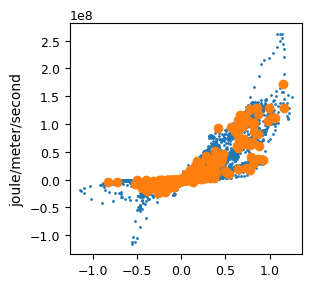

In [611]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(data['easterly'], data['length'], s=1)

# ax.scatter(data['easterly'][12::24], data['length'][12::24])

# ax.scatter(data['shelf_dma'], data['length'], s=1)

# ax.scatter(data['shelf_dma'][12::24], data['length'][12::24])


ax.scatter(data['shelf_dma'], data['iht'], s=1)

ax.scatter(data['shelf_dma'][12::24], data['iht'][12::24])

In [497]:
data['time'][Y2]

DatetimeIndex(['2017-12-01 00:00:00', '2017-12-01 01:00:00',
               '2017-12-01 02:00:00', '2017-12-01 03:00:00',
               '2017-12-01 04:00:00', '2017-12-01 05:00:00',
               '2017-12-01 06:00:00', '2017-12-01 07:00:00',
               '2017-12-01 08:00:00', '2017-12-01 09:00:00',
               ...
               '2018-04-30 14:00:00', '2018-04-30 15:00:00',
               '2018-04-30 16:00:00', '2018-04-30 17:00:00',
               '2018-04-30 18:00:00', '2018-04-30 19:00:00',
               '2018-04-30 20:00:00', '2018-04-30 21:00:00',
               '2018-04-30 22:00:00', '2018-04-30 23:00:00'],
              dtype='datetime64[ns]', length=3624, freq=None)

In [461]:
np.sum(data['extent']>0)/24

73.0

In [495]:

conversions = {}
conversions['ihc'] = 1/(cst['L_i']*cst['rho_i'])
conversions['iht'] = ((1/(cst['L_i']*cst['rho_i'])) / (100*units('km').to('m')))
final_units = {}
final_units['ihc'] = 'cm'
final_units['iht'] = 'cm/day'

#========
CAT = 'iht'
#========

print(CAT)
print()
for cond, label in zip([open_, comp_, cons_], ['Open', 'Compact', 'Totally consolidated']):
    
    print(label)

    print(' - mean:', f'{(np.nanmean(data[CAT][cond]) * conversions[CAT]).to(final_units[CAT]):.3f}')
    print(' - std:', f'{(np.nanstd(data[CAT][cond]) * conversions[CAT]).to(final_units[CAT]):.3f}')
    
    print()

iht

Open
 - mean: 14.374 centimeter / day
 - std: 12.752 centimeter / day

Compact
 - mean: 0.666 centimeter / day
 - std: 4.497 centimeter / day

Totally consolidated
 - mean: 0.048 centimeter / day
 - std: 3.206 centimeter / day



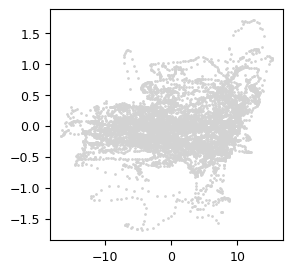

In [138]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(data["shelf_dma"], data["sig0_dma"]-data["sig0_dma_lp"], s=1)

# ax.scatter(data["shelf_dma"], data["sig0_dma"]-data["sig0_dma_lp"], s=1)

# ax.scatter(data["shelf_dma_16bf"], data["dT_dma"], s=1, c='lightgray')


# ax.scatter(data["easterly_21bf"], data["dT_dma"], s=1, c='lightgray')

ax.scatter(data["easterly_21bf"], data["sig0_dma"]-data["sig0_dma_lp"], s=1, c='lightgray')



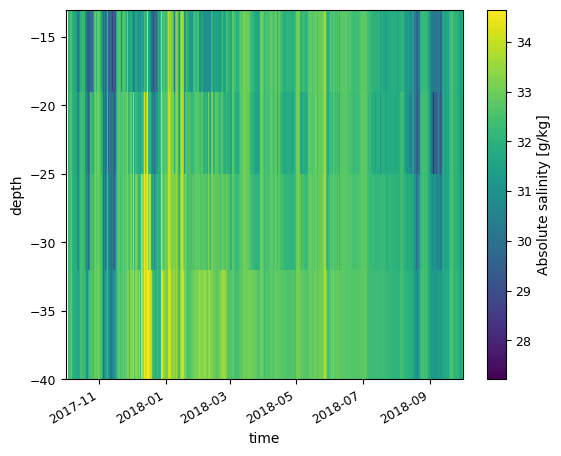

In [18]:
ds.Sa.plot()

In [ ]:

for time_range, color in zip(time_ranges, ['royalblue', 'orange', 'gold']):
    
    data = open_mooring_files(time_range, mooring = 'M1')
    data = interp_velocities(data)
    
    all_times=np.append(all_times, data['time'])
    
    all_sfc_T = np.append(all_sfc_T, data['sfc_dt'])
    all_sfc_sal = np.append(all_sfc_sal, data['sfc_sal'])
    all_sfc_sig = np.append(all_sfc_sig, data['sfc_sig'])
    all_dma_sig = np.append(all_dma_sig, data['dma_sig'])
    all_bot_sig = np.append(all_bot_sig, data['bot_sig'])
    
    all_lp_dma_sig = np.append(all_lp_dma_sig, data['lp_dma_sig'])
    all_lp_sfc_sig = np.append(all_lp_sfc_sig, data['lp_sfc_sig'])
    all_lp_bot_sig = np.append(all_lp_bot_sig, data['lp_bot_sig'])
    
    
    all_dma_T = np.append(all_dma_T, data['dma_dt'])
    all_dma_se = np.append(all_dma_se, data['dma_se'])

In [404]:

for time_range, color in zip(time_ranges, ['royalblue', 'orange', 'gold']):
    
    data = open_mooring_files(time_range, mooring = 'M1')
    data = interp_velocities(data)
    
    all_times=np.append(all_times, data['time'])
    
    all_sfc_T = np.append(all_sfc_T, data['sfc_dt'])
    all_sfc_sal = np.append(all_sfc_sal, data['sfc_sal'])
    all_sfc_sig = np.append(all_sfc_sig, data['sfc_sig'])
    all_dma_sig = np.append(all_dma_sig, data['dma_sig'])
    all_bot_sig = np.append(all_bot_sig, data['bot_sig'])
    
    all_lp_dma_sig = np.append(all_lp_dma_sig, data['lp_dma_sig'])
    all_lp_sfc_sig = np.append(all_lp_sfc_sig, data['lp_sfc_sig'])
    all_lp_bot_sig = np.append(all_lp_bot_sig, data['lp_bot_sig'])
    
    
    all_dma_T = np.append(all_dma_T, data['dma_dt'])
    all_dma_se = np.append(all_dma_se, data['dma_se'])
    
    all_ice_se = np.append(all_ice_se, data['ice_se'])
    all_ui = np.append(all_ui, data['ui'])
    all_vi = np.append(all_vi, data['vi'])
    
    all_uo = np.append(all_uo, data['uo'])
    all_vo = np.append(all_vo, data['vo'])
    
    all_u10 = np.append(all_u10, data['u10'])
    all_v10 = np.append(all_v10, data['v10'])
    
    all_extents = np.append(all_extents, data['extent'])
    all_length_145s = np.append(all_length_145s, data['length_145'])
    all_length_maxs = np.append(all_length_maxs, data['length_maxs'])
    all_poly_dirs = np.append(all_poly_dirs, data['com_directions'])
    all_poly_mldirs = np.append(all_poly_mldirs, data['max_length_directions'])
    all_openext = np.append(all_openext, data['total_open'])
    
    all_widths = np.append(all_widths, data['width'])
    all_daily_lengths = np.append(all_daily_lengths, data['length_145'][::24])
    all_daily_IHT = np.append(all_daily_IHT, data['daily_mean_IHT'][::24])
    all_IHT = np.append(all_IHT, data['IHT'])
    all_IHC = np.append(all_IHC, data['IHC'])
    all_IHT_sfc = np.append(all_IHT_sfc, data['IHT_sfc'])
    all_IHC_sfc = np.append(all_IHC_sfc, data['IHC_sfc'])
    all_months = np.append(all_months, data['month'])

    

    doy = np.array([(time - datetime(data['time'][-1].year, 1,1)).total_seconds()/(24*60*60) for time in data['time']])
    all_doy = np.append(all_doy, doy)
    
    all_years = np.append(all_years, np.full(len(data['length_145']),time_range.stop.year))

all_times = pd.to_datetime(all_times)
all_ese10 = vectors.comp_along_theta(all_u10, all_v10, 145*units('degree'))

In [32]:
def dir_conds(dff, cat):
    
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':
        
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 7.5)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 12)
    return speed_cond

<>:131: SyntaxWarning: invalid escape sequence '\m'
<>:184: SyntaxWarning: invalid escape sequence '\m'
<>:189: SyntaxWarning: invalid escape sequence '\m'
<>:199: SyntaxWarning: invalid escape sequence '\m'
<>:131: SyntaxWarning: invalid escape sequence '\m'
<>:184: SyntaxWarning: invalid escape sequence '\m'
<>:189: SyntaxWarning: invalid escape sequence '\m'
<>:199: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_87344/3344298040.py:131: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='$\mathrm{T-T_{f}\;(^{\circ}C)}$', labelpad=10,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_87344/3344298040.py:184: SyntaxWarning: invalid escape sequence '\m'
  axs[N,0].set_ylabel('Easterly\nwind\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=20, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_87344/3344298040.py:189: SyntaxWarning: invalid escape sequence

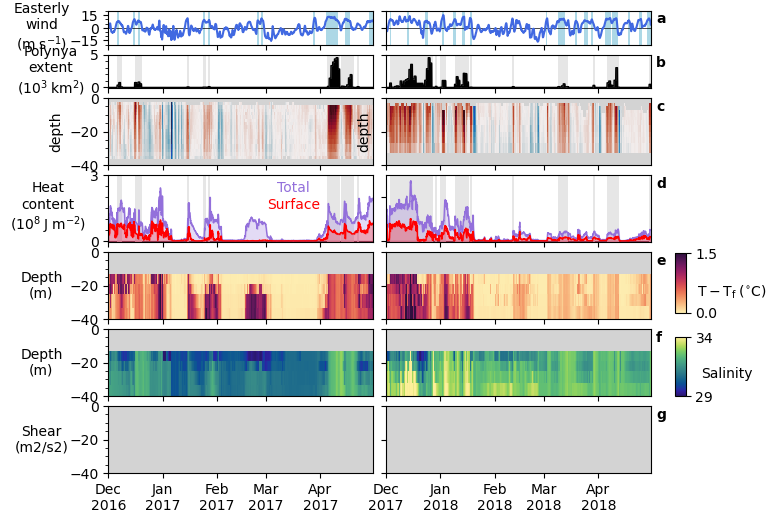

In [113]:
fig, axs = plt.subplots(7,2,figsize=(7,6), gridspec_kw={'height_ratios':[0.5,0.5,1,1,1,1,1], })


for ax, year in zip(axs[0,:], [2017, 2018]):
    ax.set_ylim(-20,20)
    
    time_cond = (all_years==year)
    
    COND = (df.year==year)
    
#     ax.plot(pd.to_datetime(df['time'][COND].values), -df['u10'][COND])
    ax.plot(all_times[time_cond], -all_u10[time_cond],  alpha=1, lw=1.5, c='royalblue')
    
    
    COND = (dir_conds(df, 'wind')&speed_conds(df, 'wind'))&(df.year==year)
    for time in pd.to_datetime(df['time'][COND].values):
#         ax.axvline(time, lw=0.5, color='b', zorder=-1000)
        ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color='lightblue', zorder=-1)
    ax.axhline(0, c='k', lw=0.5, zorder=-1)

    
# # for ax, year in zip(axs[1,:], [2017, 2018]):
# #     time_cond = (all_years==year)

# #     ax.set_ylim(-40,40)
# #     ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))
    
# #     COND = (df.year==year)
    
# #     ax.plot(pd.to_datetime(df['time'][COND].values), df['alongi_km'][COND])
    
# #     COND = (dir_conds(df, 'ice')&speed_conds(df, 'ice'))&(df.year==year)
# #     for time in pd.to_datetime(df['time'][COND].values):
# # #         ax.axvline(time, lw=0.5, color='b', zorder=-1000)
# #         ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color='lightblue', zorder=-1)
# #     ax.axhline(0, c='k', lw=0.5, zorder=-1)


# # axs[1,0].set_ylabel('Alongshore\nice drift\n$\mathrm{(km\;{d}^{-1})}$')


# polynya extent
#---------------
for ax, year in zip(axs[1,:], [2017, 2018]):    
    time_cond = (all_years==year)
    ax.set_ylim(-0.1,5)
    ax.fill_between(all_times[time_cond], all_extents[time_cond]/1000,0, lw=0, color='k')
    ax.plot(all_times[time_cond], all_extents[time_cond]/1000, color='k', lw=1)

#     ax.bar(all_times[time_cond], all_extents[time_cond]/1000, lw=0, color='k')
    
    

#     ax.set_ylim(-5,220)
#     ax.fill_between(all_times[time_cond], all_length_145s[time_cond],0, lw=0, color='k')
#     ax.plot(all_times[time_cond], all_length_145s[time_cond], color='k', lw=1)

    
    
for ax, year in zip(axs[3,:], [2017, 2018]):
    time_cond = (all_years==year)
    
    ax.axhline(0, c='k',lw=0.5,  zorder=-2)
#     ax.plot(all_times[time_cond], all_IHT[time_cond].magnitude/1e8, zorder=0, c='r', alpha=0.5)
#     ax.step(all_times[time_cond][::24], daily_mean_IHC[time_cond[::24]].magnitude/1e8, where='post', zorder=1, color='r', lw=1.5)
#     ax.fill_between(all_times[time_cond][::24], 0, daily_mean_IHC[time_cond[::24]].magnitude/1e8, step='post', alpha=0.25, color='r')

    ax.plot(all_times[time_cond], all_IHC[time_cond].magnitude/1e8, zorder=1, color='mediumpurple', lw=1)
    ax.fill_between(all_times[time_cond], 0, all_IHC[time_cond].magnitude/1e8, alpha=0.25, color='mediumpurple')
    
    ax.plot(all_times[time_cond], all_IHC_sfc[time_cond].magnitude/1e8, zorder=1, color='r', lw=1)
    ax.fill_between(all_times[time_cond], 0, all_IHC_sfc[time_cond].magnitude/1e8, alpha=0.25, color='r')
    
    ax.set_ylim(-0.05,3)
    
    
        
            
for JJ in [1,3]:
    for ax, year in zip(axs[JJ,:], [2017, 2018]):    
        for time in all_times[(all_extents>0)&(all_years==year)][::24]:
#             ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
            ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color=[0.9,0.9,0.9], zorder=-1)



for ax, year, dst in zip(axs[2,:], [2017, 2018], [ds, ds2]):
    ax.patch.set_facecolor('lightgray')
    
    DST_interp = dst.interpolate_na(dim='depth', method='linear', max_gap=20)
    DST_interp = DST_interp.interpolate_na(dim='time', method='linear', max_gap='24H')
    DST_interp.se.plot(ax=ax, vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance, add_colorbar=False)
    ax.set_ylim(-40,0)
    
#     ax.axhline(0, c='k', lw=0.5, zorder=-1)
#     ax.set_ylim(-1.5,1.75)
    
#     time_cond = (all_years==year)
    
#     ax.plot(all_times[time_cond], 
#             -all_u10[time_cond], c='gray', alpha=1, lw=1.5)
    
#     ax.plot(all_times[time_cond], 
#             all_v10[time_cond], c='k', alpha=1, lw=0.5)
#     ax.plot(all_times[time_cond], 
#             all_dma_se[time_cond]*units('m/s').magnitude, c='k', lw=1.5)

    
# ax.text(0.95,0.95, '$\mathrm{Easterly\;wind \;(m\;{s}^{-1})}$', c='gray', ha='right', va='top', transform=ax.transAxes)
# ax.text(0.95,0.15, '$\mathrm{Shelf\;current \;(*10 m\;{s}^{-1})}$', c='dodgerblue', ha='right', va='top', transform=ax.transAxes)
        
    
    
for ax in axs[4:].ravel():
    ax.set_ylim(-40,0)
    ax.patch.set_facecolor('lightgray')
# for ax in axs[4:, 1]:
#     ax.set_ylim(-40,-15)
#     ax.patch.set_facecolor('lightgray')
    
ax = axs[4][0]
ax.pcolormesh(ds6.time, ds6.depth, 
              (ds6.Ct-ds6.Tf).interpolate_na(dim='time', method='linear', max_gap='24H'), vmin=0, vmax=1.5, cmap=cmocean.cm.matter)
# plt.legend()

ax = axs[4][1]
mesh = ax.pcolormesh(dss.time, dss.depth, 
                     (dss.Ct-dss.Tf).interpolate_na(dim='time', method='linear', max_gap='24H'), vmin=0, vmax=1.5, cmap=cmocean.cm.matter)
plotter.add_colorbar(fig, ax, [mesh], cb_placement='right', cb_orientation='vertical', 
                     cb_width=0.015, cb_length_fraction=[0.1, 1], cb_pad=0.035, cb_ticks=[0,1.5], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='$\mathrm{T-T_{f}\;(^{\circ}C)}$', labelpad=10, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])



ax = axs[5][0]
ax.pcolormesh(ds6.time, ds6.depth, 
              ds6.Sp.interpolate_na(dim='time', method='linear', max_gap='24H'), vmin=29, vmax=34, cmap=cmocean.cm.haline)

ax = axs[5][1]
# for depth, color in zip([-28,-22,-16], ['mediumpurple', 'dodgerblue', 'k']):
#     ax.plot(dss.time[::sp], (dss.Sp).sel(depth=depth)[::sp], c=color, lw=1.5)
cmesh = ax.pcolormesh(dss.time, dss.depth, 
                      dss.Sp.interpolate_na(dim='time', method='linear', max_gap='24H'), vmin=29, vmax=34, cmap=cmocean.cm.haline) 
plotter.add_colorbar(fig, ax, [cmesh], cb_placement='right', cb_orientation='vertical', 
                     cb_width=0.015, cb_length_fraction=[0., 0.9], cb_pad=0.035, cb_ticks=[29,34], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Salinity', labelpad=10, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])

    
for ax in axs[:,1]:
    ax.set_yticklabels([])
    
# for ax in axs[-2:,0]:
#     ax.set_yticklabels([])
    
plt.subplots_adjust(wspace = 0.05, hspace=0.175)


        
for ax in axs[:,0]:
    year = 2017
    ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))
for ax in axs[:,1]:
    year = 2018
    ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))

for ax in axs.ravel():
    locator = mdates.MonthLocator() # Create a MonthLocator object
    ax.xaxis.set_major_locator(locator) # Set the major locator to monthly
    formatter = mdates.DateFormatter('%b\n%Y') # Define the format (e.g., YYYY-MM)
    ax.xaxis.set_major_formatter(formatter) # Apply the formatter
    
for ax in axs.ravel()[:-2]:
    ax.set_xticklabels([])
    
for aa, ax in enumerate(axs[:,1]):
    ax.text(1.02, 0.975, f'{chr(97+aa)}', weight='bold', ha='left', va='top',  transform=ax.transAxes, clip_on=False)    
    
    
N=0
axs[N,0].set_ylabel('Easterly\nwind\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(15))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

N = 1
axs[N,0].set_ylabel('Polynya\nextent\n$\mathrm{(10^{3}\;{km}^{2})}$', rotation=0, labelpad=28, va='center')  
axs[N,0].yaxis.set_major_locator(MultipleLocator(5))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(1))

N = 2
# axs[N,0].set_ylabel('Shelf\ncurrent\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=23, va='center') 
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

N = 3
axs[N,0].set_ylabel('Heat\ncontent\n$\mathrm{(10^{8}\;J\;{m}^{-2})}$', rotation=0, labelpad=30, va='center')  
axs[N,0].text(0.7, 0.75, 'Total', ha='center', c='mediumpurple', transform=axs[3,0].transAxes)
axs[N,0].text(0.7, 0.5, 'Surface',ha='center',  c='r', transform=axs[3,0].transAxes)
axs[N,0].yaxis.set_major_locator(MultipleLocator(3))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(0.5))

N = 4
axs[N,0].set_ylabel('Depth\n(m)', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

N = 5
axs[N,0].set_ylabel('Depth\n(m)', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))


N = 6
axs[N,0].set_ylabel('Shear\n(m2/s2)', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))
# fig.savefig('../figures/results/case_study_overview.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [385]:
all_lengths_145max

NameError: name 'all_lengths_145max' is not defined

<>:110: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\m'
<>:122: SyntaxWarning: invalid escape sequence '\m'
<>:110: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\m'
<>:122: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/2432369126.py:110: SyntaxWarning: invalid escape sequence '\m'
  axs[N,0].set_ylabel('Easterly\nwind\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=20, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/2432369126.py:115: SyntaxWarning: invalid escape sequence '\m'
  axs[N,0].set_ylabel('Polynya\nlength\n$\mathrm{(km)}$', rotation=0, labelpad=28, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/2432369126.py:122: SyntaxWarning: invalid escape sequence '\m'
  axs[N,0].set_ylabel('Depth\n$\mathrm{(m)}$', rotation=0, labelpad=23, va='center')


Text(0, 0.5, 'sig0')

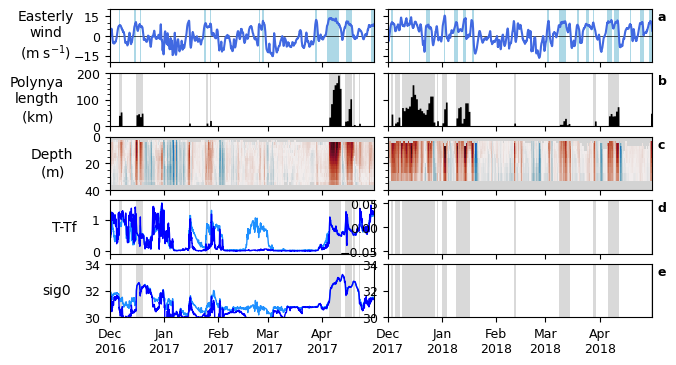

In [575]:
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda val, pos: f"{abs(val):.0f}")



fig, axs = plt.subplots(5,2,figsize=(7,4), gridspec_kw={'height_ratios':[1,1,1,1,1,], })



# winds
#---------------
for ax, year in zip(axs[0,:], [2017, 2018]):
    ax.set_ylim(-20,20)
    
    ax.yaxis.set_major_locator(MultipleLocator(15))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    
    time_cond = (all_years==year)
    ax.plot(all_times[time_cond], -all_u10[time_cond],  alpha=1, lw=1.5, c='royalblue')
    
    COND = (dir_conds(df, 'wind')&speed_conds(df, 'wind'))&(df.year==year)
    for time in pd.to_datetime(df['time'][COND].values):
        ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color='lightblue', zorder=-1)
    ax.axhline(0, c='k', lw=0.5, zorder=-1)

    

# polynya extent
#---------------
for ax, year in zip(axs[1,:], [2017, 2018]):    
    time_cond = (all_years==year)
    ax.set_ylim(0,200)
    ax.fill_between(all_times[time_cond], all_length_145s[time_cond],0, lw=0, color='k')
        
            
for JJ in [1,3,4]:
    for ax, year in zip(axs[JJ,:], [2017, 2018]):    
        for time in all_times[(all_extents>0)&(all_years==year)][::24]:
#             ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
            ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color=[0.85]*3, zorder=-1)



# shelf current
#------------------
for ax, year, dst in zip(axs[2,:], [2017, 2018], [ds, ds2]):
    ax.patch.set_facecolor('lightgray')
    DST_interp = dst.interpolate_na(dim='depth', method='linear', max_gap=20)
    DST_interp = DST_interp.interpolate_na(dim='time', method='linear', max_gap='24H')
    DST_interp.se.plot(ax=ax, vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance, add_colorbar=False)
    ax.set_ylim(-40,0)
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel('')
    
    
ax = axs[3][0]
ax.plot(ds6.time, (ds6.Ct-ds6.Tf).mean('depth'), c='dodgerblue')
ax.plot(ds6.time, (ds6.Ct-ds6.Tf).sel(depth=-16), c='b')

# plt.legend()

ax = axs[3][1]

mesh = ax.plot(dss.time, (dss.Ct-dss.Tf).mean('depth'), c='dodgerblue')
ax.plot(dss.time, (dss.Ct-dss.Tf).sel(depth=-16), c='b')


ax = axs[4][0]
ax.plot(ds6.time, (ds6.Sa).mean('depth'), c='dodgerblue')
ax.plot(ds6.time, (ds6.Sa).sel(depth=-16), c='b')
ax.set_ylim(30,34)

ax = axs[4][1]

mesh = ax.plot(dss.time, (dss.Sa).mean('depth'), c='dodgerblue')
ax.plot(dss.time, (dss.Sa).sel(depth=-16), c='b')
ax.set_ylim(30,34)
    

for aa, ax in enumerate(axs[:,1]):
    ax.text(1.02, 0.975, f'{chr(97+aa)}', weight='bold', ha='left', va='top',  transform=ax.transAxes, clip_on=False)    
    
    

plt.subplots_adjust(wspace = 0.05, hspace=0.2)


        
for ax in axs[:,0]:
    year = 2017
    ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))
for ax in axs[:,1]:
    year = 2018
    ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))

for ax in axs.ravel():
    locator = mdates.MonthLocator() # Create a MonthLocator object
    ax.xaxis.set_major_locator(locator) # Set the major locator to monthly
    formatter = mdates.DateFormatter('%b\n%Y') # Define the format (e.g., YYYY-MM)
    ax.xaxis.set_major_formatter(formatter) # Apply the formatter
    
for ax in axs.ravel()[:-2]:
    ax.set_xticklabels([])
    
    
    
N=0
axs[N,0].set_ylabel('Easterly\nwind\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=20, va='center')
axs[N,1].set_yticklabels([])

N = 1
# axs[N,0].set_ylabel('Polynya\nextent\n$\mathrm{(10^{3}\;{km}^{2})}$', rotation=0, labelpad=28, va='center')  
axs[N,0].set_ylabel('Polynya\nlength\n$\mathrm{(km)}$', rotation=0, labelpad=28, va='center') 
axs[N,0].yaxis.set_major_locator(MultipleLocator(100))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(20))
axs[N,1].set_yticklabels([])

N = 2
# axs[N,0].set_ylabel('Shelf\ncurrent\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=23, va='center') 
axs[N,0].set_ylabel('Depth\n$\mathrm{(m)}$', rotation=0, labelpad=23, va='center') 
axs[N,1].set_yticklabels([])



N = 3
axs[N,0].set_ylabel('T-Tf', rotation=0, labelpad=20, va='center')
# axs[N,0].set_ylabel('Heat\ncontent\n$\mathrm{(10^{8}\;J\;{m}^{-2})}$', rotation=0, labelpad=30, va='center')  
# axs[N,0].text(0.7, 0.75, 'Total', ha='center', c='mediumpurple', transform=axs[3,0].transAxes)
# axs[N,0].text(0.7, 0.5, 'Surface',ha='center',  c='r', transform=axs[3,0].transAxes)
# axs[N,0].yaxis.set_major_locator(MultipleLocator(3))
# axs[N,0].yaxis.set_minor_locator(MultipleLocator(0.5))

N = 4
axs[N,0].set_ylabel('sig0', rotation=0, labelpad=20, va='center')
# axs[N,0].set_ylabel('Depth\n(m)', rotation=0, labelpad=20, va='center')
# axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
# axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))


In [ ]:

# N = 5
# axs[N,0].set_ylabel('Depth\n(m)', rotation=0, labelpad=20, va='center')
# axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
# axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))


# N = 5
# axs[N,0].set_ylabel('Shear\n(m2/s2)', rotation=0, labelpad=20, va='center')
# axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
# axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))
#     ax.plot(all_times[time_cond], all_length_145s[time_cond], color='k', lw=1)

#     1000
# for ax, year in zip(axs[3,:], [2017, 2018]):
#     time_cond = (all_years==year)
    
#     ax.axhline(0, c='k',lw=0.5,  zorder=-2)
# #     ax.plot(all_times[time_cond], all_IHT[time_cond].magnitude/1e8, zorder=0, c='r', alpha=0.5)
# #     ax.step(all_times[time_cond][::24], daily_mean_IHC[time_cond[::24]].magnitude/1e8, where='post', zorder=1, color='r', lw=1.5)
# #     ax.fill_between(all_times[time_cond][::24], 0, daily_mean_IHC[time_cond[::24]].magnitude/1e8, step='post', alpha=0.25, color='r')

#     ax.plot(all_times[time_cond], all_IHC[time_cond].magnitude/1e8, zorder=1, color='mediumpurple', lw=1)
#     ax.fill_between(all_times[time_cond], 0, all_IHC[time_cond].magnitude/1e8, alpha=0.25, color='mediumpurple')
    
#     ax.plot(all_times[time_cond], all_IHC_sfc[time_cond].magnitude/1e8, zorder=1, color='r', lw=1)
#     ax.fill_between(all_times[time_cond], 0, all_IHC_sfc[time_cond].magnitude/1e8, alpha=0.25, color='r')
    
#     ax.set_ylim(-0.05,3)
    
    

In [ ]:
# for ax in axs[:,1]:
#     ax.set_yticklabels([])
    
# for ax in axs[-2:,0]:
#     ax.set_yticklabels([])

# ax = axs[5][0]

# z_vals = [-17.3,-5.3]
# du = ds6.u.sel(depth=z_vals).diff('depth')
# dv = ds6.v.sel(depth=z_vals).diff('depth')
# dz = ds6.sel(depth=z_vals).depth.diff('depth').squeeze()
# bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()
# ax.plot(ds6.time, bulkshear)


# ax = axs[5][0]
# ax.set_ylim(-0.0005,0.004)



# z_vals = [-39,-16]
# dp = ds6.sig0.sel(depth=z_vals).diff('depth')
# dz = ds6.sel(depth=z_vals).depth.diff('depth').squeeze()
# N2 = ((-9.8/1000)*(dp/dz)).squeeze()
# ax.plot(ds6.time, N2)


# time_range = slice(datetime(2016,12,1), datetime(2017,4,30,23))
# open_years = '2016_2017'
# time_cond = df.year==2017
# mooring='M1'
# dso = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
# z_vals = [-17.3,-5.3]
# du = dso.u.sel(depth=z_vals).diff('depth')
# dv = dso.v.sel(depth=z_vals).diff('depth')
# dz = dso.sel(depth=z_vals).depth.diff('depth').squeeze()
# bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()
# ax.plot(dso.time, bulkshear**2, alpha=0.5)



# ax = axs[5][1]
# ax.set_ylim(-0.0005,0.004)

# z_vals = [-36,-16]
# dss = dss.sel(time=slice(datetime(2016,12,1), datetime(2017,4,30,23)))
# dp = dss.sig0.sel(depth=z_vals).diff('depth')
# dz = dss.sel(depth=z_vals).depth.diff('depth').squeeze()
# N2 = ((-9.8/1000)*(dp/dz)).squeeze()
# ax.plot(dss.time, N2)



# time_range = slice(datetime(2017,12,1), datetime(2018,4,30,23))
# open_years = '2017_2018'
# time_cond = df.year==2018
# mooring='M1'
# dso = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
# z_vals = [-18,-6]
# du = dso.u.sel(depth=z_vals).diff('depth')
# dv = dso.v.sel(depth=z_vals).diff('depth')
# dz = dso.sel(depth=z_vals).depth.diff('depth').squeeze()
# bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()
# ax.plot(dso.time, bulkshear**2, alpha=0.5)



# time_range = slice(datetime(2017,12,1), datetime(2018,4,30,23))
# open_years = '2017_2018'
# time_cond = df.year==2018




In [428]:
(180/6) * (2/3)

20.0

In [424]:
320/7

45.714285714285715

In [ ]:
all_length_145s

In [416]:
U0 = np.nanmean(all_uo[all_length_145s>0])
V0 = np.nanmean(all_vo[all_length_145s>0])

(90*units('degree') - vectors.vector_angle(U0, V0)) + 360*units('degree')

<Quantity(306.483591, 'degree')>

In [411]:
all_uo[all_length_145s>0]

array([-0.12709476, -0.14057592, -0.16053507, ..., -0.54580674,
       -0.52729597, -0.50605376])

In [ ]:
all_dma_se[all_length_145s>0]

In [ ]:
plt

In [401]:
df[df.sequence==99].time

4546    2017-12-09
4547    2017-12-10
4548    2017-12-11
4549    2017-12-12
4550    2017-12-13
4551    2017-12-14
4552    2017-12-15
4553    2017-12-16
4554    2017-12-17
4555    2017-12-18
4556    2017-12-19
4557    2017-12-20
4558    2017-12-21
4559    2017-12-22
4560    2017-12-23
4561    2017-12-24
4562    2017-12-25
4563    2017-12-26
4564    2017-12-27
Name: time, dtype: object

In [ ]:
all_lengths

In [386]:
all_lengths

NameError: name 'all_lengths' is not defined

In [226]:
open_years

'2017_2018'

In [233]:
DSO = {}

for year in [2017,2018]:
    
    mooring='M1'
    open_years = f"{year-1}_{year}"
    DSO[year] = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
    
    DSO[year] = DSO[year].sel(time=slice(datetime(year-1,12,1), datetime(year, 4,30,23)))
    
    
    
DSS = {}

for year in [2017,2018]:
    
    mooring='M1'
    open_years = f"{year-1}_{year}"
    DSS[year] = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
    
    DSS[year] = DSS[year].sel(time=slice(datetime(year-1,12,1), datetime(year, 4,30,23)))
    

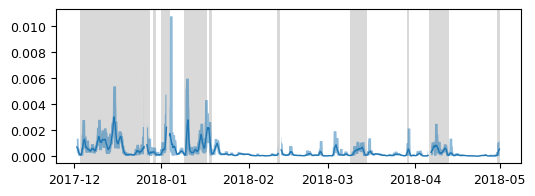

In [361]:

year = 2018

du = DSO[year].u.diff('depth')
dv = DSO[year].v.diff('depth')
dz = DSO[year].depth.diff('depth').squeeze()
bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()

fig, ax = plt.subplots(figsize=(6,2))
# ax.patch.set_facecolor('lightgray')

for JJ in [1,3,4,5]:    
    for time in all_times[(all_extents>0)&(all_years==year)][::24]:
#             ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
        ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color=[0.85]*3, zorder=-1)

# ax.pcolormesh(DSO[year].time, DSO[year].depth[:-1], np.log(bulkshear**2), vmin=-12, vmax=0)

# ax.plot(DSO[year].time, bulkshear.mean('depth')**2)


ax.plot(DSO[year].time, bulkshear.mean('depth').rolling(time=24).mean()**2)

ax.fill_between(DSO[year].time, bulkshear.mean('depth').rolling(time=24).min()**2,  
                bulkshear.mean('depth').rolling(time=24).max()**2, alpha=0.5, lw=0)

In [378]:

year = 2018

# z_vals = [-17.3,-5.3]
z_vals = [-30,-8]
du = DSO[year].u.sel(depth=z_vals).diff('depth')
dv = DSO[year].v.sel(depth=z_vals).diff('depth')
dz = DSO[year].sel(depth=z_vals).depth.diff('depth').squeeze()
bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()

# du = DSO[year].u.sel(depth=slice(-40,-17.3)).mean('depth') - DSO[year].u.sel(depth=slice(-17.3, 0)).mean('depth')
# dv = DSO[year].v.sel(depth=slice(-40,-17.3)).mean('depth') - DSO[year].v.sel(depth=slice(-17.3, 0)).mean('depth')
# dz = DSO[year].sel(depth=z_vals).depth.diff('depth').squeeze()
# bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()


# du = DSO[year].u.sel(depth=slice(-40,-18)).mean('depth') - DSO[year].u.sel(depth=slice(-18, 0)).mean('depth')
# dv = DSO[year].v.sel(depth=slice(-40,-18)).mean('depth') - DSO[year].v.sel(depth=slice(-18, 0)).mean('depth')
# dz = DSO[year].sel(depth=z_vals).depth.diff('depth').squeeze()
# bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()

# z_vals = [-39,-16]
z_vals = [-36,-16]
dp = DSS[year].sig0.sel(depth=z_vals).diff('depth')
dz = DSS[year].sel(depth=z_vals).depth.diff('depth').squeeze()
N2 = ((-9.8/1000)*(dp/dz)).squeeze()

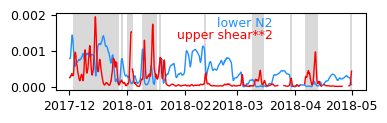

In [379]:
fig, ax = plt.subplots(figsize=(4,1))

# dso.v.mean('depth')
# ax.scatter(N2, bulkshear**2, s=1)

# ax.scatter(DSO[year].v.mean('depth'), (N2/bulkshear**2), s=1)

# ax.plot(DSO[year].time, (N2/bulkshear**2))

# ax.plot(DSO[year].time, (N2))

# ax.fill_between(DSO[year].time, (N2.rolling(time=24, min_periods=12).mean()), 0, color='dodgerblue', alpha=0.35,  lw=0)
ax.plot(DSO[year].time, (N2.rolling(time=24, min_periods=12).mean()), color='dodgerblue', lw=1)
ax.text(0.7,0.95, 'lower N2', ha='right', va='top', color='dodgerblue', transform=ax.transAxes)


# ax.plot(DSO[year].time, (bulkshear.rolling(time=24, min_periods=12).mean()**2), lw=1.5)
# ax.plot(DSO[year].time, (bulkshear**2), lw=1)

# ax.fill_between(DSO[year].time, (bulkshear.rolling(time=24, min_periods=12).mean()**2), 0, color='orange', alpha=0.35,  lw=0)
ax.plot(DSO[year].time, (bulkshear.rolling(time=24, min_periods=12).mean()**2), color='r', lw=1)
ax.text(0.7,0.8, 'upper shear**2', ha='right', va='top', color='r', transform=ax.transAxes)

# ax.fill_between(DSO[year].time, (bulkshear.rolling(time=24, min_periods=12).min()**2),
#                (bulkshear.rolling(time=24, min_periods=12).max()**2), alpha=0.5,color='orange',  lw=0)


for JJ in [1,3,4,5]:    
    for time in all_times[(all_extents>0)&(all_years==year)][::24]:
#             ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
        ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color=[0.85]*3, zorder=-1)



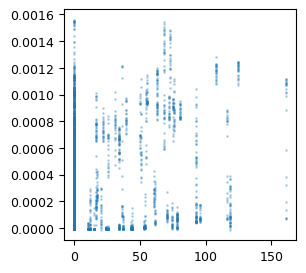

In [384]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter((N2),
#            (bulkshear**2), s=1, alpha=0.25)

# ax.scatter(all_length_145s[all_years==2018],
#            (bulkshear**2), s=1, alpha=0.25)

ax.scatter(all_length_145s[all_years==2018],
           N2, s=1, alpha=0.25)

In [ ]:
ax.scatter()

In [564]:
all_IHC

Magnitude,[105103139.73903504 105737291.20449054 106272795.53693506 ... 49494143.337870054 49331439.259941414 48828890.94262738]
Units,joule/meter2


In [ ]:
# # for ax, year in zip(axs[1,:], [2017, 2018]):    
# #     time_cond = (all_years==year)
# #     ax.set_ylim(-2000,2000)
# #     ax.plot(all_times[time_cond], all_IHT[time_cond].magnitude/10e4, color='r', lw=1)
    
    
# # for ax, year in zip(axs[2,:], [2017, 2018]):  
    
# #     ax.axhline(0, c='k', lw=0.5, zorder=-1)
# #     ax.set_ylim(-20,20)
    
# #     time_cond = (all_years==year)
    
# #     ax.plot(all_times[time_cond], 
# #             -all_u10[time_cond], c='gray', alpha=1, lw=1.5)
    
# #     COND = (dir_conds(df, 'wind')&speed_conds(df, 'wind'))&(df.year==year)
# #     ax.scatter(df['time'][COND], df['s10'][COND])


In [516]:
axs[4:].ravel()

array([<Axes: >, <Axes: >, <Axes: ylabel='Depth (m)'>, <Axes: >,
       <Axes: ylabel='Depth (m)'>, <Axes: >], dtype=object)

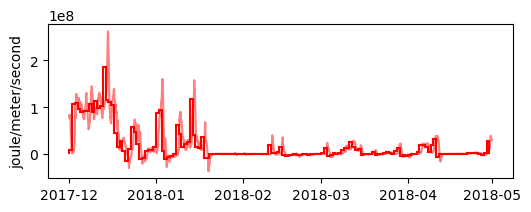

In [517]:
fig, ax = plt.subplots(figsize=(6,2))
plt.plot(all_times[time_cond], all_IHT[time_cond], zorder=0, c='r', alpha=0.5)
plt.stairs(all_daily_IHT[time_cond[::24]][1:], edges = all_times[time_cond][::24], zorder=1, color='r', lw=1.5)

(-1.0, 3.0)

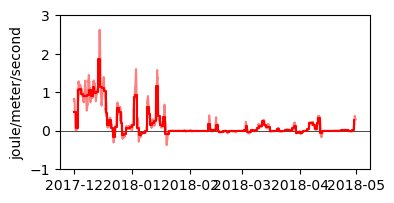

In [506]:
fig, ax = plt.subplots(figsize=(4,2))
ax.axhline(0, c='k',lw=0.5,  zorder=-2)
plt.plot(all_times[time_cond], all_IHT[time_cond]/1e8, zorder=0, c='r', alpha=0.5)
plt.step(all_times[time_cond][::24], all_daily_IHT[time_cond[::24]]/1e8, where='post', zorder=1, color='r', lw=1.5)
ax.set_ylim(-1,3)
# plt.step(all_times[time_cond][::24], all_daily_IHT[time_cond[::24]][:], zorder=1, color='r', lw=1.5, where='post')

In [507]:
len(all_daily_IHT)

302

In [508]:
(convert / units('day')).to('W/m2')

<Quantity(3.54488426e+08, 'watt / meter ** 2')>

In [509]:
np.nanpercentile(all_sfc_T[all_extents>0], 75)

0.9069975043996434

In [510]:
np.nanpercentile(all_sfc_T[all_extents==0], 50)

0.04676212937760016

In [129]:
np.nanpercentile(all_sfc_T[all_extents==0], 75)

0.21210273338494523

In [ ]:
'width_ratios':[]

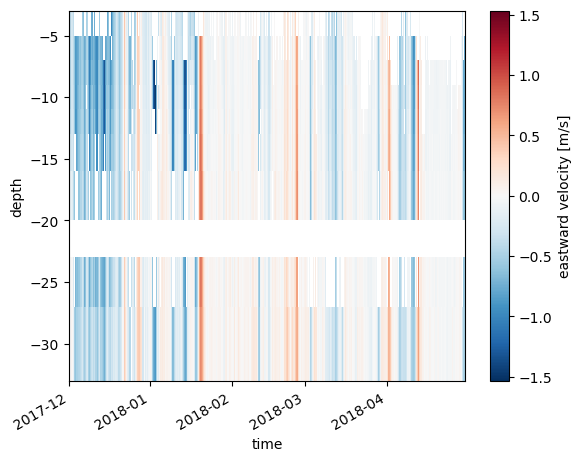

In [580]:
dso = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_2017_2018.nc')
dso = dso.sel(time = time_ranges[1])
dso.u.plot()


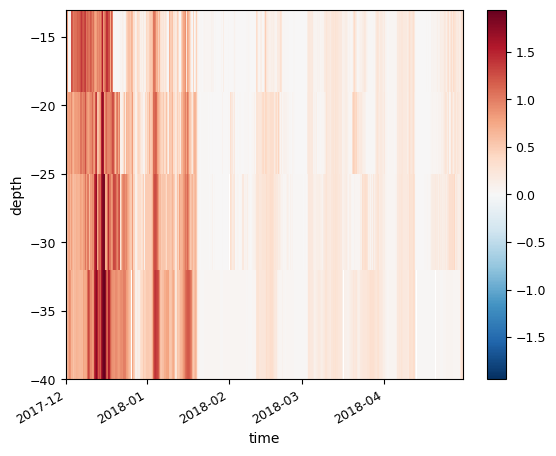

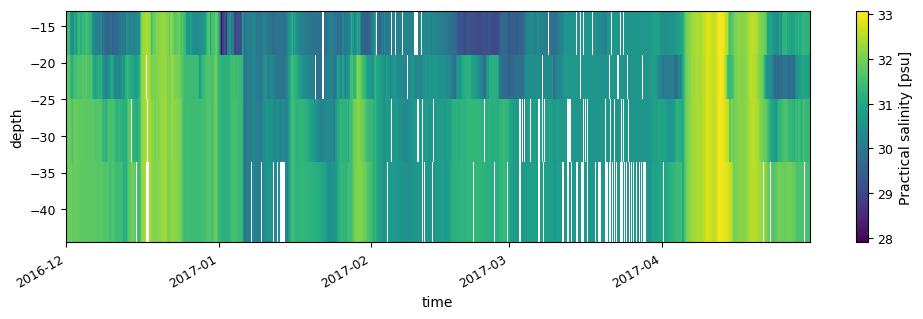

In [421]:
dss = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_2017_2018.nc')
dss = dss.sel(time = time_ranges[1])
(dss.Ct-dss.Tf).plot()

fig, ax = plt.subplots(figsize=(12,3))
ds6 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_2016_2017.nc')
ds6 = ds6.sel(time = time_ranges[0])
# (ds6.Ct-ds6.Tf).plot()
(ds6.Sp).plot()


In [61]:
df['time'][COND], df['s10'][COND]

(Series([], Name: time, dtype: object), Series([], Name: s10, dtype: float64))

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48184/3741301750.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.95,0.95, '$\mathrm{Polynya\;extent \;({km}^{2})}$', c='k', ha='right', va='top', transform=ax.transAxes)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48184/3741301750.py:38: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.95,0.95, '$\mathrm{Easterly\;wind \;(m\;{s}^{-1})}$', c='gray', ha='right', va='top', transform=ax.transAxe

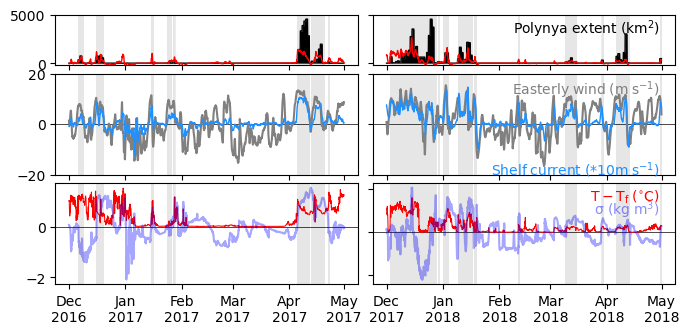

In [511]:
fig, axs = plt.subplots(3,2,figsize=(8,3.5), gridspec_kw={'height_ratios':[1,2,2]})


    
for ax, year in zip(axs[0,:], [2017, 2018]):    
    
    time_cond = (all_years==year)
    
    ax.set_ylim(-200,5000)
    ax.fill_between(all_times[time_cond], all_extents[time_cond],0, lw=0, color='k')
    ax.plot(all_times[time_cond], all_extents[time_cond], color='k', lw=1)
    ax.plot(all_times[time_cond], all_IHT[time_cond].magnitude/10e4, color='r', lw=1)
    
    
    for time in all_times[(all_extents>0)&(all_years==year)]:
        ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
        
ax.text(0.95,0.95, '$\mathrm{Polynya\;extent \;({km}^{2})}$', c='k', ha='right', va='top', transform=ax.transAxes)

for ax, year in zip(axs[1,:], [2017, 2018]):
    ax.axhline(0, c='k', lw=0.5, zorder=-1)
    ax.set_ylim(-20,20)
    
    time_cond = (all_years==year)
    
    ax.plot(all_times[time_cond], 
            -all_u10[time_cond], c='gray', alpha=1, lw=1.5)
    
#     ax.plot(all_times[time_cond], 
#             all_v10[time_cond], c='k', alpha=1, lw=0.5)
    ax.plot(all_times[time_cond], 
            10*all_dma_se[time_cond], c='dodgerblue', lw=1)
    
    for time in all_times[(all_extents>0)&(all_years==year)]:
        ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
        
        
ax.text(0.95,0.95, '$\mathrm{Easterly\;wind \;(m\;{s}^{-1})}$', c='gray', ha='right', va='top', transform=ax.transAxes)
ax.text(0.95,0.15, '$\mathrm{Shelf\;current \;(*10 m\;{s}^{-1})}$', c='dodgerblue', ha='right', va='top', transform=ax.transAxes)
        
    
for ax, year in zip(axs[2,:], [2017, 2018]):
    ax.axhline(0, c='k', lw=0.5, zorder=-1)
#     ax.set_ylim(-1.9,1.9)
    ax.plot(all_times[all_years==year], all_sfc_T[all_years==year], c='r', lw=0.75)    
#     ax.plot(all_times[all_years==year], 
#             (all_dma_sig-26)[all_years==year], c='b', alpha=0.35)
    
    ax.plot(all_times[all_years==year], 
            (all_sfc_sig-all_lp_sfc_sig)[all_years==year], c='b', alpha=0.35)
    
#     all_lp_dma_sig
    
#     ax.plot(all_times[all_years==year], 
#             (all_dma_sig-all_lp_dma_sig)[all_years==year], c='k', alpha=0.35)
    
    for time in all_times[(all_extents>0)&(all_years==year)]:
        ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
        
        
ax.text(0.95,0.95, '$\mathrm{T - T_{f} \;(^{\circ}C)}$', c='r', ha='right', va='top', transform=ax.transAxes)
ax.text(0.95,0.85, '$\mathrm{\sigma}$ ($\mathrm{kg\;{m}^3}$)', c='b', alpha=0.45, ha='right', va='top', transform=ax.transAxes)

for ax in axs[:,1]:
    ax.set_yticklabels([])
    
plt.subplots_adjust(wspace = 0.05, hspace=0.1)

for ax in axs.ravel():
    locator = mdates.MonthLocator() # Create a MonthLocator object
    ax.xaxis.set_major_locator(locator) # Set the major locator to monthly
    formatter = mdates.DateFormatter('%b\n%Y') # Define the format (e.g., YYYY-MM)
    ax.xaxis.set_major_formatter(formatter) # Apply the formatter
    
for ax in axs.ravel()[:-2]:
    ax.set_xticklabels([])
    
    


# fig.savefig('../figures/results/case_study_overview.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [25]:
len(all_IHT)

8736

In [26]:
len(all_length_145s)

8736

In [496]:
daily_mean_IHT/1e8

<Quantity([-1.44371396e-02  2.10582293e-01  9.80317860e-03  3.81111240e-02
 -1.03573099e-02  2.50650513e-01  5.27105068e-01  1.95356502e-01
 -2.99655249e-02 -1.11126187e-01  1.32536207e-02  2.26698624e-01
 -5.68013180e-02 -3.18115311e-03  2.43317617e-01  7.45581055e-01
  6.85551797e-02  4.81604811e-01  2.80621683e-01  2.34120035e-02
 -7.50558237e-02 -1.16855360e-01 -8.35434755e-02 -1.94510399e-01
 -1.58951002e-01 -8.12165129e-02  1.09530226e-01  1.46299487e-01
  1.29489389e-01  6.89365534e-01 -1.41218987e-01 -2.31218389e-01
 -8.52903059e-02 -1.56557232e-01 -9.34785329e-02 -1.19706950e-01
 -9.78821923e-02 -1.11465828e-03 -8.33132258e-03 -4.35412730e-03
 -7.30124561e-03 -1.01428135e-02 -9.65438831e-03 -5.36867729e-04
  1.50546891e-02  4.96879705e-01 -7.00214975e-02  5.49013821e-02
 -9.26131527e-05 -1.11064459e-02 -8.29787461e-03 -4.95968800e-03
 -1.18061920e-02 -8.32559366e-03  5.36061162e-02  2.11189870e-01
  2.45595134e-01  3.09947558e-01  2.63076492e-01  5.31663790e-02
 -5.96683017e-02 -3.93718586e-02 -2.71779888e-01 -2.14178618e-01
 -1.32597111e-01 -9.61149293e-03  1.60360701e-03  1.77014644e-03
  1.01282109e-03 -2.61701907e-03 -4.19578483e-03 -1.62648486e-03
 -1.08684102e-03  4.73163780e-03 -5.88306698e-04  2.77656803e-04
 -1.49836727e-03  6.87123561e-03  2.97100559e-02  3.61023740e-02
  7.30508069e-02  1.11470893e-01  2.82903171e-02 -2.57944069e-02
 -4.28656141e-02  9.49831453e-02  6.72008502e-02  4.63110615e-02
  1.31670275e-01 -1.13336635e-01 -7.68785463e-02 -1.37697537e-02
 -2.10602882e-02 -1.02126618e-02 -1.48145489e-04 -9.93209260e-04
  6.42811847e-05 -8.60412332e-06  3.02645925e-03 -2.75870152e-03
 -8.75571494e-04 -2.00645421e-03 -7.09594537e-05 -6.69927241e-04
 -1.00798354e-03 -1.88257748e-04  4.99585978e-04  2.36620202e-04
  1.20591564e-04  5.73901815e-04  5.59178197e-04  6.22250854e-04
  1.08041817e-03  6.72960481e-04 -3.45328795e-04 -1.21855307e-03
 -5.02335948e-04  1.46917652e-03  6.14624450e-03  4.82561454e-03
  1.21037052e-02  7.37640839e-03  1.96810841e-02  3.09466245e-02
  6.12142214e-02  9.52747740e-01  1.28562936e+00  1.12341676e+00
  1.00012356e+00  9.92131207e-01  6.26768648e-01  3.32966752e-01
 -7.34066603e-02 -3.63024016e-02  2.71935766e-01  7.67019198e-01
  7.26914272e-01  7.13504536e-01  5.77431339e-01  8.33048780e-02
  4.81881851e-02  4.69860060e-02  3.56189299e-01  3.14536118e-01
  9.47806462e-02  4.06654080e-02  4.97010808e-02  1.02609877e-01
  4.10280715e-01  3.12823055e-01  1.95218333e-01  4.96997306e-01
  7.30604558e-02  1.05922141e+00  1.08674761e+00  9.67262170e-01
  8.98714984e-01  9.10705363e-01  9.26000492e-01  1.06502614e+00
  9.03777776e-01  1.14078186e+00  9.87028307e-01  1.01765682e+00
  1.86679005e+00  1.14426462e+00  1.10783892e+00  1.04064213e+00
  4.50065563e-01  1.37926033e-01  2.83995073e-01  6.56008578e-02
 -1.49175335e-01  1.08528364e-01  5.84904895e-01  4.75511877e-01
  2.13651621e-01 -1.02866335e-01 -9.22789464e-02  6.92047565e-02
  7.50287701e-02  8.60701363e-02  1.53603450e-01  8.72141352e-01
  9.40036789e-01  6.73526897e-02 -1.00773340e-01 -7.03304270e-02
 -5.19031378e-02 -1.22157890e-02  6.18050426e-01  4.34663107e-01
  1.56826984e-01  2.00489281e-01  2.63338573e-01  1.16908989e+00
  3.95906649e-01  1.49472448e-01  1.30542587e-01  3.64873029e-01
 -8.48657207e-02 -8.29058697e-02 -6.51805253e-03  8.14493644e-04
  7.31356638e-04 -1.10910646e-03 -3.15122311e-04  9.67701754e-05
 -2.20650163e-03 -1.47333486e-04 -3.33086664e-06 -2.53525150e-03
 -2.36767214e-03  5.02231015e-03 -4.70794814e-03 -5.24051554e-03
 -1.89735447e-03 -1.48038263e-03 -5.98060830e-03 -3.15231487e-03
 -3.47746783e-03 -4.70652431e-03 -7.84252345e-03  1.83703386e-01
  1.30584728e-02  8.03097614e-03  2.97270947e-02  1.53063434e-01
 -1.68328603e-02 -3.78354933e-02 -2.16126671e-02 -1.64934524e-02
 -8.07267420e-04 -3.23671064e-02 -1.62096347e-02 -5.78601488e-03
 -8.99827678e-03 -1.70758474e-02 -7.04273219e-03 -4.42575568e-04
 -1.53919950e-03 -1.76363679e-03  1.09026454e-02  1.22016914e-01
 -4.35551309e-02 -2.12810

In [518]:
# daily_mean_IHT = np.array([])
# for ii in np.arange(0, len(all_IHT), 24):
#     daily_mean_IHT = np.append(daily_mean_IHT, np.nansum(all_IHT.to('J/m/hour')[ii:ii+24]*units('hour')))
    
    
daily_mean_u10 = np.array([])
for ii in np.arange(0, len(all_u10), 24):
    daily_mean_u10 = np.append(daily_mean_u10, np.nanmean(all_u10[ii:ii+24]))
    

    
daily_mean_IHT = np.array([])
for ii in np.arange(0, len(all_IHT), 24):
    daily_mean_IHT = np.append(daily_mean_IHT, np.nanmean(all_IHT.to('J/m/s')[ii:ii+24]))
    
    
daily_mean_IHC = np.array([])
for ii in np.arange(0, len(all_IHC), 24):
    daily_mean_IHC = np.append(daily_mean_IHC, np.nanmean(all_IHC.to('J/m2')[ii:ii+24]))
    
    
daily_mean_current = np.array([])
for ii in np.arange(0, len(all_dma_se), 24):
    daily_mean_current = np.append(daily_mean_current, np.nansum(all_dma_se[ii-0:ii+24]*units('m/s').to('km/hour')*units('hour')))
    
daily_mean_sfc_t = np.array([])
for ii in np.arange(0, len(all_sfc_T), 24):
    daily_mean_sfc_t = np.append(daily_mean_sfc_t, np.nanmean(all_sfc_T[ii-0:ii+24]))
    
daily_mean_dma_sig = np.array([])
for ii in np.arange(0, len(all_dma_sig), 24):
    daily_mean_dma_sig = np.append(daily_mean_dma_sig, np.nanmean(all_dma_sig[ii-0:ii+24]))
    
daily_mean_dma_sig_lp = np.array([])
for ii in np.arange(0, len(all_lp_dma_sig), 24):
    daily_mean_dma_sig_lp = np.append(daily_mean_dma_sig_lp, np.nanmean(all_lp_dma_sig[ii-0:ii+24]))
    
    
daily_mean_sfc_sig = np.array([])
for ii in np.arange(0, len(all_sfc_sig), 24):
    daily_mean_sfc_sig = np.append(daily_mean_sfc_sig, np.nanmean(all_sfc_sig[ii-0:ii+24]))
    
daily_mean_sfc_sig_lp = np.array([])
for ii in np.arange(0, len(all_lp_sfc_sig), 24):
    daily_mean_sfc_sig_lp = np.append(daily_mean_sfc_sig_lp, np.nanmean(all_lp_sfc_sig[ii-0:ii+24]))
    
    
daily_mean_sfc_sal = np.array([])
for ii in np.arange(0, len(all_sfc_sal), 24):
    daily_mean_sfc_sal = np.append(daily_mean_sfc_sal, np.nanmean(all_sfc_sal[ii-0:ii+24]))

daily_mean_u10 = np.array([])
for ii in np.arange(0, len(all_u10), 24):
    daily_mean_u10 = np.append(daily_mean_u10, np.nanmean(all_u10[ii-0:ii+24]))

all_u10

array([-1.36343062, -1.00738227, -0.76599014, ..., -5.62870741,
       -4.56007338, -3.82553005])

In [ ]:
daily_mean_sfc_sig-daily_mean_sfc_sig_lp

In [453]:
# all_widths = np.array([])
# all_daily_lengths = np.array([])
# all_daily_IHT = np.array([])
# all_years = np.array([])
# all_times = np.array([], dtype=np.datetime64)
# all_sfc_T = np.array([])
# all_sfc_sal = np.array([])
# all_dma_sig = np.array([])
# all_bot_sig = np.array([])
# all_sfc_sig = np.array([])
# all_lp_dma_sig = np.array([])
# all_lp_sfc_sig = np.array([])
# all_lp_bot_sig = np.array([])

# all_dma_T = np.array([])
# all_dma_se = np.array([])
# all_ice_se = np.array([])
# all_IHT = np.array([])
# all_IHC = np.array([])
# all_IHT_sfc = np.array([])
# all_IHC_sfc = np.array([])
# all_months = np.array([])
# all_doy = np.array([])
# all_u10 = np.array([])
# all_v10 = np.array([])

# all_ui = np.array([])
# all_vi = np.array([])

# all_uo = np.array([])
# all_vo = np.array([])

In [ ]:
# all_times = np.array([], dtype=np.datetime64)
# all_sfc_T = np.array([])
# all_sfc_sal = np.array([])
# all_dma_sig = np.array([])
# all_bot_sig = np.array([])
# all_sfc_sig = np.array([])
# all_lp_dma_sig = np.array([])
# all_lp_sfc_sig = np.array([])
# all_lp_bot_sig = np.array([])


In [ ]:
all_length_145s

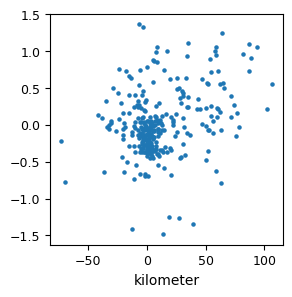

In [541]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(-daily_mean_u10, 
#         all_length_145s[::24], marker='o')


# ax.scatter(-daily_mean_u10, daily_mean_dma_sig-daily_mean_dma_sig_lp, s=5)

# ax.scatter(-daily_mean_u10, daily_mean_dma_sig-daily_mean_dma_sig_lp, s=5)


ax.scatter(daily_mean_current, daily_mean_dma_sig-daily_mean_dma_sig_lp, s=5)


# ax.scatter(-daily_mean_u10, daily_mean_sfc_t)




# ax.plot(-daily_mean_u10, all_length_145s[::24], marker='o')

In [494]:
all_length_145s

array([ 0.        ,  0.        ,  0.        , ..., 48.44958602,
       48.44958602, 48.44958602])

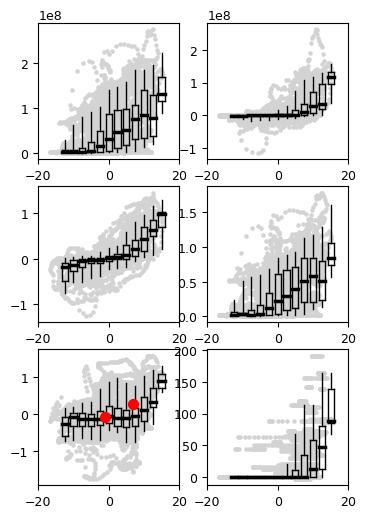

In [625]:
fig, AXS = plt.subplots(3,2,figsize=(4,6))

axs = AXS.ravel()

# x values
#==================================
lag = 21

X = -all_u10[:-lag]
cbin_edges = np.arange(-20,20.1,2.5)
#==================================
cbin_width = np.diff(cbin_edges)[0]
cbin_centers = cbin_edges[:-1] + cbin_width



open_ = (all_length_145s[:-lag] > 0)
comp_ = (all_length_145s[:-lag] == 0)

for ax in axs:
    ax.set_xlim(-20,20)


ax = axs[0]

Y = (all_IHC.magnitude)[lag:]
vals = generate_dist(X, Y, cbin_edges)

ax.scatter(X, Y, c='lightgray', s=5)
plot_dist(ax, vals, cbin_centers, cbin_width)


ax = axs[1]

Y = (all_IHT.magnitude)[lag:]
vals = generate_dist(X, Y, cbin_edges)

ax.scatter(X, Y, c='lightgray', s=5)

plot_dist(ax, vals, cbin_centers, cbin_width)


ax = axs[2]

Y = (all_dma_se)[lag:]
vals = generate_dist(X, Y, cbin_edges)
ax.scatter(X, Y, c='lightgray', s=5)
plot_dist(ax, vals, cbin_centers, cbin_width)


ax = axs[3]

Y = (all_dma_T)[lag:]
vals = generate_dist(X, Y, cbin_edges)
ax.scatter(X, Y, c='lightgray', s=5)
plot_dist(ax, vals, cbin_centers, cbin_width)


ax = axs[4]

Y = (all_dma_sig-all_lp_dma_sig)[lag:]
vals = generate_dist(X, Y, cbin_edges)
ax.scatter(X, Y, c='lightgray', s=5)
plot_dist(ax, vals, cbin_centers, cbin_width)

ax.scatter(np.nanmean(X[open_]), np.nanmean(Y[open_]), c='r', s=50)
ax.scatter(np.nanmean(X[comp_]), np.nanmean(Y[comp_]), c='r', s=50)


ax = axs[5]

Y = all_length_145s[lag:]
vals = generate_dist(X, Y, cbin_edges)
ax.scatter(X, Y, c='lightgray', s=5)
plot_dist(ax, vals, cbin_centers, cbin_width)

In [601]:
def generate_dist(xvals, yvals, bin_edges):
    
    # dictionary to save info
    percents = [5,25,50,75,95]
    vals = {}
    for per in percents:
        vals[per] = np.array([])

    # find those within bins
    for bl, br in zip(bin_edges[:-1], bin_edges[1:]):

        within_bin = (xvals>=bl) & (xvals<br)

        if np.sum(within_bin)>48:   #### MUST include at least N observations
            vals_within = yvals[within_bin]
        else:
            vals_within = [np.nan]
        for per in percents:
            vals[per] = np.append(vals[per], np.nanpercentile(vals_within, per))

    return vals
    
    
    
def plot_dist(ax, vals, bin_centers, bin_width):
    
    for cc in range(len(bin_centers)):

        ww = 0.35*bin_width
        ax.plot([bin_centers[cc]-ww]*2, [vals[25][cc], vals[75][cc]], c='k', zorder=1)
        ax.plot([bin_centers[cc]+ww]*2, [vals[25][cc], vals[75][cc]], c='k', zorder=1)
        ax.plot([bin_centers[cc]+ww,bin_centers[cc]-ww], [vals[25][cc]]*2, c='k', zorder=1)
        ax.plot([bin_centers[cc]+ww,bin_centers[cc]-ww], [vals[75][cc]]*2, c='k', zorder=1)
        ax.plot([bin_centers[cc]+ww,bin_centers[cc]-ww], [vals[50][cc]]*2, c='k', lw=2.5, zorder=1)

        # whiskr=ers
        ax.plot([bin_centers[cc]]*2, [vals[5][cc],vals[25][cc]], c='k', zorder=1)
        ax.plot([bin_centers[cc]]*2, [vals[75][cc],vals[95][cc]], c='k', zorder=1)


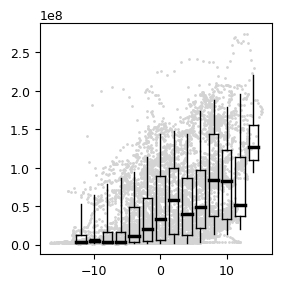

In [593]:
fig, ax = plt.subplots(figsize=(3,3))




# X = all_dma_se[:-lag]



# X = -daily_mean_u10

# # Y = (all_dma_sig-all_lp_dma_sig)[lag:]

# Y = (all_dma_se)[lag:]

Y = (all_IHC.magnitude)[lag:]

# Y = (all_IHT.magnitude)[lag:]/1e8

# Y = (all_length_145s)[lag:]

# Y = all_daily_lengths
# Y = (all_dma_T)[lag:]
# Y = (all_sfc_T)[lag:]



ax.scatter(X, Y, s=1, c='lightgray')



# ax.scatter(X[all_length_145s[:-lag]==0], Y[all_length_145s[:-lag]==0], s=1, c='lightcoral')
# ax.scatter(X[all_length_145s[:-lag]>0], Y[all_length_145s[:-lag]>0], s=1, c='b')



# ax.scatter(all_dma_se[:-lag], all_IHT[lag:], s=1, c='lightgray')

# ax.scatter(cbin_centers, vals[50], c='k')



# ax.set_ylim(-0.5,2)
# ax.set_xlim(-1,1.5)


In [456]:

    
    print(bl,br)

1.7399999999999993 1.9599999999999995


In [52]:
help(plotter.quick_hist(vals, bin_edges=[]))

Help on module plot_simply.general in plot_simply:

NAME
    plot_simply.general - # Functions for plotting

CLASSES
    matplotlib.colors.Normalize(builtins.object)
        TwopointNormalize

    class TwopointNormalize(matplotlib.colors.Normalize)
     |  TwopointNormalize(vmin=None, vmax=None, vmid1=None, vmid2=None, clip=False)
     |
     |  Class for normalizing colormap based off two midpoints.
     |
     |  INPUT:
     |  - vmin: min value
     |  - vmid1: lower midpoint value
     |  - vmid2: higher midpoint value
     |  - vmax: max value
     |
     |  OUTPUT:
     |  - normalization scaling [vmin, vmid1, vmid2, vmax] to [0, 1/3, 2/3, 1] of colormap
     |
     |  Latest recorded update:
     |  12-17-2024
     |
     |  Method resolution order:
     |      TwopointNormalize
     |      matplotlib.colors.Normalize
     |      builtins.object
     |
     |  Methods defined here:
     |
     |  __call__(self, value, clip=None)
     |      Normalize *value* data in the ``[vmin

In [115]:
daily_mean_IHT

<Quantity([-1.44371396e+06  2.10582293e+07  9.80317860e+05  3.81111240e+06
 -1.03573099e+06  2.50650513e+07  5.27105068e+07  1.95356502e+07
 -2.99655249e+06 -1.11126187e+07  1.32536207e+06  2.26698624e+07
 -5.68013180e+06 -3.18115311e+05  2.43317617e+07  7.45581055e+07
  6.85551797e+06  4.81604811e+07  2.80621683e+07  2.34120035e+06
 -7.50558237e+06 -1.16855360e+07 -8.35434755e+06 -1.94510399e+07
 -1.58951002e+07 -8.12165129e+06  1.09530226e+07  1.46299487e+07
  1.29489389e+07  6.89365534e+07 -1.41218987e+07 -2.31218389e+07
 -8.52903059e+06 -1.56557232e+07 -9.34785329e+06 -1.19706950e+07
 -9.78821923e+06 -1.11465828e+05 -8.33132258e+05 -4.35412730e+05
 -7.30124561e+05 -1.01428135e+06 -9.65438831e+05 -5.36867729e+04
  1.50546891e+06  4.96879705e+07 -7.00214975e+06  5.49013821e+06
 -9.26131527e+03 -1.11064459e+06 -8.29787461e+05 -4.95968800e+05
 -1.18061920e+06 -8.32559366e+05  5.36061162e+06  2.11189870e+07
  2.45595134e+07  3.09947558e+07  2.63076492e+07  5.31663790e+06
 -5.96683017e+06 -3.93718586e+06 -2.71779888e+07 -2.14178618e+07
 -1.32597111e+07 -9.61149293e+05  1.60360701e+05  1.77014644e+05
  1.01282109e+05 -2.61701907e+05 -4.19578483e+05 -1.62648486e+05
 -1.08684102e+05  4.73163780e+05 -5.88306698e+04  2.77656803e+04
 -1.49836727e+05  6.87123561e+05  2.97100559e+06  3.61023740e+06
  7.30508069e+06  1.11470893e+07  2.82903171e+06 -2.57944069e+06
 -4.28656141e+06  9.49831453e+06  6.72008502e+06  4.63110615e+06
  1.31670275e+07 -1.13336635e+07 -7.68785463e+06 -1.37697537e+06
 -2.10602882e+06 -1.02126618e+06 -1.48145489e+04 -9.93209260e+04
  6.42811847e+03 -8.60412332e+02  3.02645925e+05 -2.75870152e+05
 -8.75571494e+04 -2.00645421e+05 -7.09594537e+03 -6.69927241e+04
 -1.00798354e+05 -1.88257748e+04  4.99585978e+04  2.36620202e+04
  1.20591564e+04  5.73901815e+04  5.59178197e+04  6.22250854e+04
  1.08041817e+05  6.72960481e+04 -3.45328795e+04 -1.21855307e+05
 -5.02335948e+04  1.46917652e+05  6.14624450e+05  4.82561454e+05
  1.21037052e+06  7.37640839e+05  1.96810841e+06  3.09466245e+06
  6.12142214e+06  9.52747740e+07  1.28562936e+08  1.12341676e+08
  1.00012356e+08  9.92131207e+07  6.26768648e+07  3.32966752e+07
 -7.34066603e+06 -3.63024016e+06  2.71935766e+07  7.67019198e+07
  7.26914272e+07  7.13504536e+07  5.77431339e+07  8.33048780e+06
  4.81881851e+06  4.69860060e+06  3.56189299e+07  3.14536118e+07
  9.47806462e+06  4.06654080e+06  4.97010808e+06  1.02609877e+07
  4.10280715e+07  3.12823055e+07  1.95218333e+07  4.96997306e+07
  7.30604558e+06  1.05922141e+08  1.08674761e+08  9.67262170e+07
  8.98714984e+07  9.10705363e+07  9.26000492e+07  1.06502614e+08
  9.03777776e+07  1.14078186e+08  9.87028307e+07  1.01765682e+08
  1.86679005e+08  1.14426462e+08  1.10783892e+08  1.04064213e+08
  4.50065563e+07  1.37926033e+07  2.83995073e+07  6.56008578e+06
 -1.49175335e+07  1.08528364e+07  5.84904895e+07  4.75511877e+07
  2.13651621e+07 -1.02866335e+07 -9.22789464e+06  6.92047565e+06
  7.50287701e+06  8.60701363e+06  1.53603450e+07  8.72141352e+07
  9.40036789e+07  6.73526897e+06 -1.00773340e+07 -7.03304270e+06
 -5.19031378e+06 -1.22157890e+06  6.18050426e+07  4.34663107e+07
  1.56826984e+07  2.00489281e+07  2.63338573e+07  1.16908989e+08
  3.95906649e+07  1.49472448e+07  1.30542587e+07  3.64873029e+07
 -8.48657207e+06 -8.29058697e+06 -6.51805253e+05  8.14493644e+04
  7.31356638e+04 -1.10910646e+05 -3.15122311e+04  9.67701754e+03
 -2.20650163e+05 -1.47333486e+04 -3.33086664e+02 -2.53525150e+05
 -2.36767214e+05  5.02231015e+05 -4.70794814e+05 -5.24051554e+05
 -1.89735447e+05 -1.48038263e+05 -5.98060830e+05 -3.15231487e+05
 -3.47746783e+05 -4.70652431e+05 -7.84252345e+05  1.83703386e+07
  1.30584728e+06  8.03097614e+05  2.97270947e+06  1.53063434e+07
 -1.68328603e+06 -3.78354933e+06 -2.16126671e+06 -1.64934524e+06
 -8.07267420e+04 -3.23671064e+06 -1.62096347e+06 -5.78601488e+05
 -8.99827678e+05 -1.70758474e+06 -7.04273219e+05 -4.42575568e+04
 -1.53919950e+05 -1.76363679e+05  1.09026454e+06  1.22016914e+07
 -4.35551309e+06 -2.12810

In [51]:
cum_pack_drifts = np.array([])

open_dates = pd.to_datetime(all_times[all_extents>0][::24])
df_times = pd.to_datetime(df.time.values)


for ii in range(len(open_dates)):
    curr_date = open_dates[ii]
    
    seq = df[df_times==curr_date].sequence.values[0]
    ed = df[df_times==curr_date].event_day.values[0]
    
    day_before_ind = df[(df.sequence==seq)&(df.event_day==1)].index.values[0] -1
    day_during_ind = df[(df.sequence==seq)&(df.event_day==ed)].index.values[0]

#     up_to_day_during = (df.sequence==seq)&(df.event_day<=ed)

#     total_pack = - np.cumsum(0.04 * df[day_before_ind:day_during_ind].u10.values * units('m/s').to('km/day'))[-1]

    total_pack = - np.cumsum(df[day_before_ind:day_during_ind].ui.values * units('cm/s').to('km/day'))[-1]

    cum_pack_drifts = np.append(cum_pack_drifts, total_pack.magnitude)

IndexError: index 0 is out of bounds for axis 0 with size 0

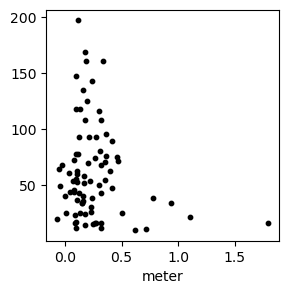

In [16]:
fig, ax= plt.subplots(figsize=(3,3))

# ax.scatter(cum_pack_drifts, all_extents[all_extents>0][::24]/50)

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24], s=10, c='k', alpha=1)

# ax.scatter((daily_mean_IHT/convert).to('cm'), all_length_145s[::24], s=10, c='k', alpha=1)

# ax.scatter(daily_mean_IHT/10e12, 
#            all_length_145s[::24], s=10, c='k', alpha=1)


L = 50 * units('km').to('m')
L = all_length_145s[::24]* units('km').to('m')
ax.scatter(daily_mean_IHT/(L*cst['L_i']*cst['rho_i']), 
           all_length_145s[::24], s=10, c='k', alpha=1)



# /(cst['rho_i'] * cst['L_i'])
# ax.scatter(((daily_mean_IHT/(cst['rho_i'] * cst['L_i']))/(all_length_145s[::24]*units('km'))).to('cm'), all_length_145s[::24], s=10, c='k', alpha=1)


In [374]:
final_days

NameError: name 'final_days' is not defined

In [93]:
AW_events = (all_times[::24] > datetime(2017,12,5)) & (all_times[::24] < datetime(2018,2,1))

# AW_events = (all_years[::24]==2018) & (AW_events==False)

In [94]:
print(all_times[::24][nonAW_events]);
print(all_times[::24][yesAW_events]);

DatetimeIndex(['2017-12-03', '2017-12-04', '2017-12-05', '2018-02-11',
               '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12',
               '2018-03-13', '2018-03-14', '2018-03-29', '2018-04-06',
               '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10',
               '2018-04-11', '2018-04-12', '2018-04-30'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-12-06', '2017-12-07', '2017-12-08', '2017-12-09',
               '2017-12-10', '2017-12-11', '2017-12-12', '2017-12-13',
               '2017-12-14', '2017-12-15', '2017-12-16', '2017-12-17',
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-29', '2018-01-01',
               '2018-01-02', '2018-01-03', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14',
               '2018-01-15', '2018-01-16'

In [95]:
nonAW_events = ((AW_events==False)&(all_extents[::24]>0))&(all_years[::24]==2018)
yesAW_events = (AW_events)&(all_extents[::24]>0)

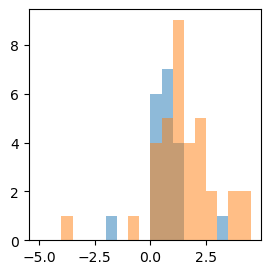

In [96]:
fig, ax = plt.subplots(figsize=(3,3))
# plt.hist(all_length_145s[::24][nonAW_events], alpha=0.5);
# plt.hist(all_length_145s[::24][yesAW_events], alpha=0.5);

plt.hist((all_length_145s[::24]/daily_mean_current)[nonAW_events], alpha=0.5, bins=np.arange(-5,5,0.5));
plt.hist((all_length_145s[::24]/daily_mean_current)[yesAW_events], alpha=0.5, bins=np.arange(-5,5,0.5));

In [97]:
np.sum(AW_events)

57

In [35]:
import matplotlib.ticker as ticker

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/357229131.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Shelf current velocity\n($\mathrm{km\;{d}^{-1}}$)")
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/357229131.py:55: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat content\n($\mathrm{10^{8}\;J\;{m}^{-2}}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/357229131.py:76: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat transport\n($\mathrm{10^{8}\;W\;{m}^{-1}}$)')


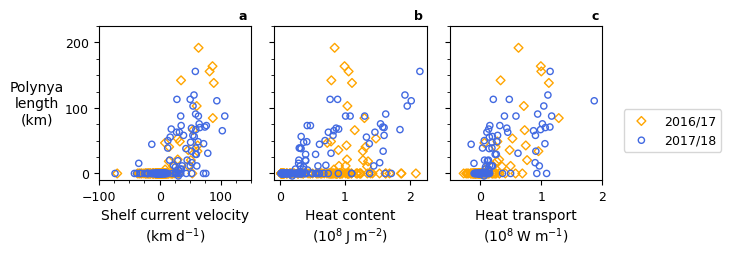

In [429]:
fig, axs = plt.subplots(1,3,figsize=(6.5,2))

# ax.scatter(cum_pack_drifts, all_extents[all_extents>0][::24]/50)

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24], s=10, c='k', alpha=1)



m1_kwargs = {'edgecolor' : 'orange', 'marker' : 'D', 'facecolor':'None',  's':20, 'alpha':1,}

m2_kwargs = {'edgecolor' : 'royalblue', 'marker' : 'o',  'facecolor':'None', 's':20, 'alpha':1,}


mo_kwargs = {'edgecolor' : 'k', 'marker' : 'o', 'facecolor':'r',  's':30, 'alpha':1,}
lo_kwargs = {'c':'r', 'lw':1, 'alpha':1,}
mc_kwargs = {'edgecolor' : 'k', 'marker' : 'o', 'facecolor':'dodgerblue',  's':30, 'alpha':1,}
lc_kwargs = {'c':'dodgerblue', 'lw':1, 'alpha':1,}

Y1 = (all_years[::24]==2017)
Y2 = (all_years[::24]==2018)

#-------------------------
ax = axs[0]
ax.set_xlabel("Shelf current velocity\n($\mathrm{km\;{d}^{-1}}$)")
ax.set_ylabel('Polynya\nlength\n(km)', rotation=0, labelpad=20, va='center')
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(25))
ax.set_xlim(-100,150)

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    ax.scatter(daily_mean_current[cond], 
               all_length_145s[::24][cond],label=lab, **kw)



# for cond, lk, mk, Y in zip([all_extents[::24]==0, all_extents[::24]>0], 
#                         [lc_kwargs, lo_kwargs], [mc_kwargs, mo_kwargs], [250,260]):
    
#     ax.plot([np.nanpercentile(daily_mean_current.magnitude[cond], 25), 
#                 np.nanpercentile(daily_mean_current.magnitude[cond], 75)], [Y,Y], clip_on=False, **lk)
    
#     ax.scatter(np.nanpercentile(daily_mean_current.magnitude[cond], 50), Y, clip_on=False, **mk)



# ax.plot(daily_mean_current, all_length_145s[::24],  c='k', alpha=1)
# ax.plot([0,150],[0,150])


#-------------------------

ax = axs[1]
ax.set_xlabel('Heat content\n($\mathrm{10^{8}\;J\;{m}^{-2}}$)')

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    ax.scatter(daily_mean_IHC.magnitude[cond]/1e8, 
               all_length_145s[::24][cond],**kw)
  


# for cond, lk, mk, Y in zip([all_extents[::24]==0, all_extents[::24]>0], 
#                         [lc_kwargs, lo_kwargs], [mc_kwargs, mo_kwargs], [250,260]):
    
#     ax.plot([np.nanpercentile(daily_mean_IHC.magnitude[cond]/1e8, 25), 
#                 np.nanpercentile(daily_mean_IHC.magnitude[cond]/1e8, 75)], [Y,Y], clip_on=False, **lk)
    
#     ax.scatter(np.nanpercentile(daily_mean_IHC.magnitude[cond]/1e8, 50), Y, clip_on=False, **mk)



#-------------------------
ax = axs[2]
ax.set_xlabel('Heat transport\n($\mathrm{10^{8}\;W\;{m}^{-1}}$)')
ax.set_xlim(-0.5,2)
for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    ax.scatter(daily_mean_IHT.to('W/m').magnitude[cond]/1e8, 
               all_length_145s[::24][cond],label=lab, **kw)


# for cond, lk, mk, Y in zip([all_extents[::24]==0, all_extents[::24]>0], 
#                         [lc_kwargs, lo_kwargs], [mc_kwargs, mo_kwargs], [250,260]):
    
#     ax.plot([np.nanpercentile(daily_mean_IHT.to('W/m').magnitude[cond]/1e8, 25), 
#                 np.nanpercentile(daily_mean_IHT.to('W/m').magnitude[cond]/1e8, 75)], [Y,Y], clip_on=False, **lk)
    
#     ax.scatter(np.nanpercentile(daily_mean_IHT.to('W/m').magnitude[cond]/1e8, 50), Y, clip_on=False, **mk)

axs[2].legend(bbox_to_anchor=(1.1,0.5))
    
# ax.set_ylabel('Polynya length')

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24]/cum_pack_drifts, s=10, c='k', alpha=1)

# ax.set_ylim(-1,10)

plt.subplots_adjust(wspace=0.15)


for ax in axs:
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(25))
    ax.set_ylim(-10,225)
for ax in axs[1:]:
    ax.set_yticklabels([])

for aa, ax in enumerate(axs):
    ax.text(0.975,1.025, f'{chr(aa+97)}',va='bottom', ha='right', weight='bold', transform=ax.transAxes)

# fig.savefig('../figures/results/Fig10b.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [442]:
all_sfc_sal

array([31.74233479, 31.74554635, 31.74232633, ..., 32.84990188,
       32.85643684, 32.85879838])

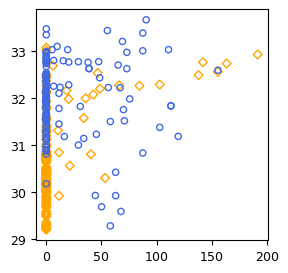

In [448]:
fig, ax = plt.subplots(figsize=(3,3))

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

#     ax.scatter(daily_mean_sfc_sig[cond], 
#                all_length_145s[::24][cond],label=lab, **kw)


#     ax.scatter(daily_mean_current[cond],
#                daily_mean_sfc_sal[cond],label=lab, **kw)

    ax.scatter(all_length_145s[::24][cond&(all_length_145s[::24]>0)],
               daily_mean_sfc_sal[cond&(all_length_145s[::24]>0)],label=lab, **kw)
    
    
    ax.scatter(all_length_145s[::24][cond&(all_length_145s[::24]==0)],
               daily_mean_sfc_sal[cond&(all_length_145s[::24]==0)],label=lab, **kw)

    

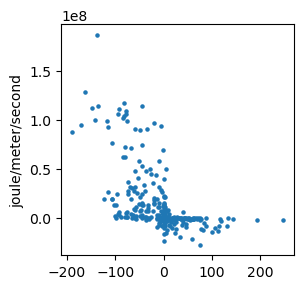

In [124]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(np.sign(daily_mean_u10)*daily_mean_u10**2, daily_mean_IHT, s=5)